In [1]:
import numpy as np
import cv2
import glob
import matplotlib.pyplot as plt
%matplotlib inline

# Steps

* Camera calibration
* Distorsion correction
* color and Gradient Threshold (binary image)
* Perspective Transform

# Camera Calibration 

## First look

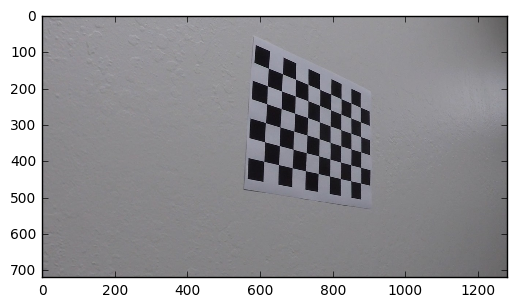

In [2]:
imgs_calibration = glob.glob("camera_cal/calibration*.jpg")

img = cv2.imread(imgs_calibration[1])
img = cv2.cvtColor(img, cv2.COLOR_BGR2RGB)
plt.imshow(img)

## Camera calibration matrix

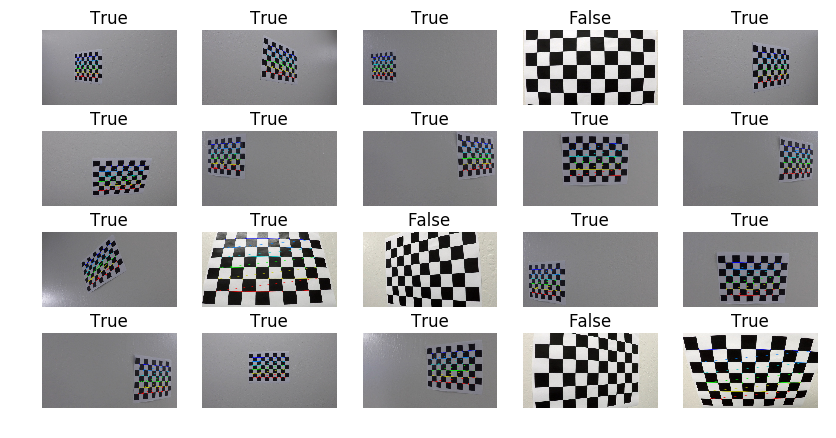

(1280, 720)
1.0298153371058978


In [3]:
nx = 9 #number of corners in a row
ny = 6 #numbers or corners in a column

# Arrays to store object points and image points from all the images

objpoints = [] #3D points in real world space
imgpoints = [] #2D points in image plane

#Prepare object points, like (0,0,0), (1, 0,0)
objp = np.zeros((nx * ny, 3), np.float32)
objp[:,:2] = np.mgrid[0:nx,0:ny].T.reshape(-1,2) #x, y coordinate

_, ax = plt.subplots(int(np.ceil(len(imgs_calibration)/5)), 5, figsize=(10,5))
row, col = [0, 0]
for img_adress in imgs_calibration:
    #Convert chessboard image form RGB to gray
    img = cv2.imread(img_adress)
    img = cv2.cvtColor(img, cv2.COLOR_BGR2RGB)
    gray = cv2.cvtColor(img, cv2.COLOR_RGB2GRAY)
    # Find the chessboard corners
    ret, corners = cv2.findChessboardCorners(gray, (nx, ny), None)
    #Draw corners
    if ret:
        imgpoints.append(corners)
        objpoints.append(objp)
        img = cv2.drawChessboardCorners(img, (nx, ny), corners, ret)
    ax[row, col].imshow(img)
    ax[row,col].set_axis_off()
    ax[row, col].set_title(ret)
    if col==4:
        row = row + 1
        col = 0
    else:
        col = col + 1

plt.show()

# Image calibration: mtx
#calibrateCamera(objectpoints, imagepoints, shape of image)
#return camera matrix (mtx), distorsion coefficient (dist), 
# position of the camera in the world: rvecs (rotation and translation vectors)
print(gray.shape[::-1])
ret, mtx, dist, rvecs, tvecs = cv2.calibrateCamera(objpoints, imgpoints, gray.shape[::-1], None, None)
print(ret)

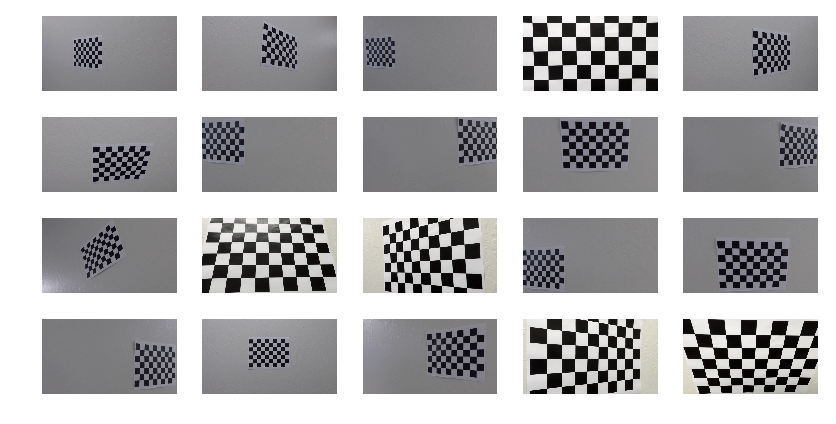

In [4]:
#CORRECTING FOR DISTORSION
#Undistort image

_, ax = plt.subplots(int(np.ceil(len(imgs_calibration)/5)), 5, figsize=(10,5))
row, col = [0, 0]
    
    
for img_adress in imgs_calibration:
    #Convert chessboard image form RGB to gray
    img = cv2.imread(img_adress)
    img = cv2.cvtColor(img, cv2.COLOR_BGR2RGB)
    #undistort takes a distorted image and return destination image undistorted
    dst = cv2.undistort(img, mtx, dist, None, mtx)
    
    ax[row, col].imshow(dst)
    ax[row,col].set_axis_off()
    if col==4:
        row = row + 1
        col = 0
    else:
        col = col + 1

plt.show()


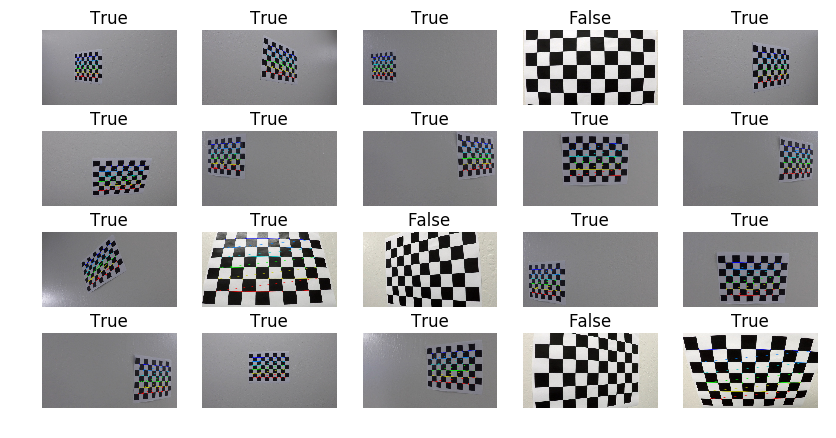

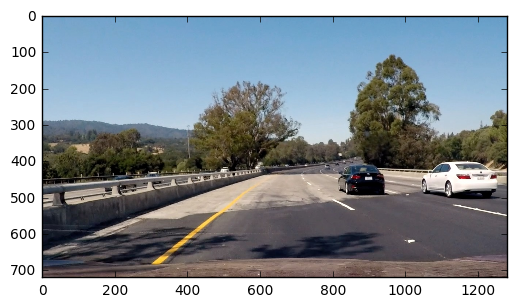

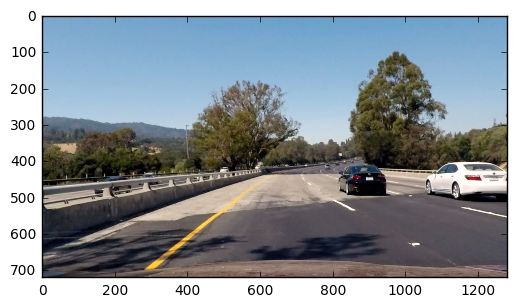

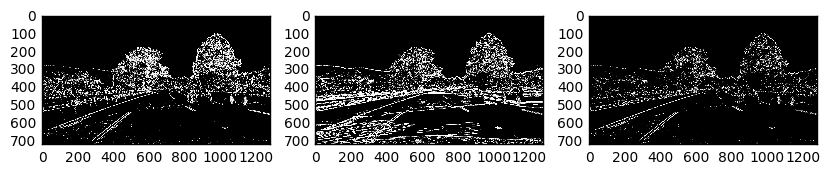

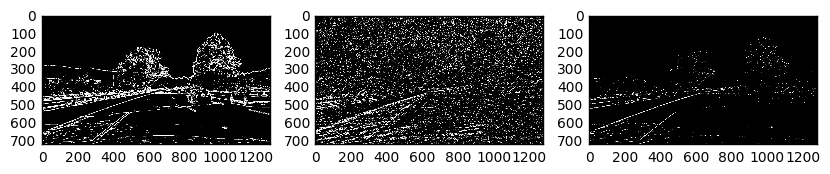

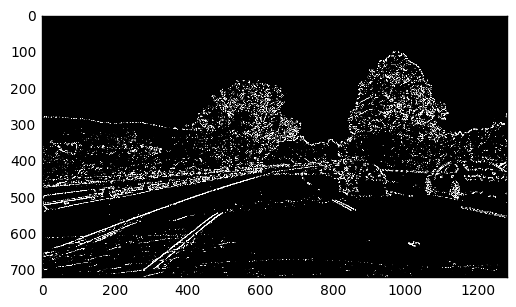

In [5]:
def camera_calibration(calibration_files, nx, ny):
    # Arrays to store object points and image points from all the images
    objpoints = [] #3D points in real world space
    imgpoints = [] #2D points in image plane

    #Prepare object points, like (0,0,0), (1, 0,0)
    objp = np.zeros((nx * ny, 3), np.float32)
    objp[:,:2] = np.mgrid[0:nx,0:ny].T.reshape(-1,2) #x, y coordinate

    _, ax = plt.subplots(int(np.ceil(len(calibration_files)/5)), 5, figsize=(10,5))
    row, col = [0, 0]
    for img_adress in calibration_files:
        #Convert chessboard image form RGB to gray
        img = cv2.imread(img_adress)
        img = cv2.cvtColor(img, cv2.COLOR_BGR2RGB)
        gray = cv2.cvtColor(img, cv2.COLOR_RGB2GRAY)
        # Find the chessboard corners
        ret, corners = cv2.findChessboardCorners(gray, (nx, ny), None)
        #Draw corners
        if ret:
            imgpoints.append(corners)
            objpoints.append(objp)
            img = cv2.drawChessboardCorners(img, (nx, ny), corners, ret)
        ax[row, col].imshow(img)
        ax[row,col].set_axis_off()
        ax[row, col].set_title(ret)
        if col==4:
            row = row + 1
            col = 0
        else:
            col = col + 1

    plt.show()

    # Image calibration: mtx
    #calibrateCamera(objectpoints, imagepoints, shape of image)
    #return camera matrix (mtx), distorsion coefficient (dist), 
    # position of the camera in the world: rvecs (rotation and translation vectors)
    return cv2.calibrateCamera(objpoints, imgpoints, gray.shape[::-1], None, None)


def image_correction(img, mtx, dist):
    dst = cv2.undistort(img, mtx, dist, None, mtx)
    return dst


#COLOR & GRADIENT THRESHOLD (BINARY IMAGE)

def directional_gradient(img, direction='x', ksize=3, thresh=[0, 255] ):
    #convert image to gray scale
    gray = cv2.cvtColor(img, cv2.COLOR_RGB2GRAY)

    #Get gradient along direction
    if direction == 'x':
        sobel = cv2.Sobel(gray, cv2.CV_64F, 1,0, ksize)
    elif direction == 'y':
        sobel = cv2.Sobel(gray, cv2.CV_64F, 0, 1, ksize)
    #Take absolute value
    sobel_abs = np.absolute(sobel)
    #turn sobel to 8bit image 0-255 intensity range
    scaled_sobel = np.uint8(sobel_abs * 255/np.max(sobel_abs))
    #binary
    binary_output = np.zeros_like(sobel)
    binary_output[(scaled_sobel>= thresh[0]) & (scaled_sobel <= thresh[1]) ] = 1
    return binary_output


def mag_gradient(img, thresh=[0, 255], ksize=3):
    #convert image to gray scale
    gray = cv2.cvtColor(img, cv2.COLOR_RGB2GRAY)
    #Get gradient along direction
    sobelx = cv2.Sobel(gray, cv2.CV_64F, 1,0, ksize)
    sobely = cv2.Sobel(gray, cv2.CV_64F, 0, 1, ksize)
    #Take absolute value
    gradient_mag = np.sqrt( np.square(sobelx) + np.square(sobely))
    #turn sobel to 8bit image 0-255 intensity range
    scaled_gradient_mag = np.uint8(gradient_mag * 255/np.max(gradient_mag))
    #binary
    binary_output = np.zeros_like(gradient_mag)
    binary_output[(scaled_gradient_mag>= thresh[0]) & (scaled_gradient_mag <= thresh[1]) ] = 1
    return binary_output


def gradient_direction(img, thresh=[0, np.pi/2], ksize=3):
    #convert image to gray scale
    gray = cv2.cvtColor(img, cv2.COLOR_RGB2GRAY)
    #Get gradient along direction
    sobelx = cv2.Sobel(gray, cv2.CV_64F, 1,0, ksize)
    sobely = cv2.Sobel(gray, cv2.CV_64F, 0, 1, ksize)
    #Take absolute value
    gradient_dir = np.arctan2( sobely, sobelx)
    #turn sobel to 8bit image 0-255 intensity range
    #binary
    binary_output = np.zeros_like(gradient_dir)
    binary_output[(gradient_dir>= thresh[0]) & (gradient_dir <= thresh[1]) ] = 1
    return binary_output


def hls_binary(img, chl_thresh=[0,255], chs_thresh=[0,255]):
    assert len(img.shape) == 3, 'img does not have 3 color channels'
    hls = cv2.cvtColor(img, cv2.COLOR_RGB2HLS)
    l_binary = np.zeros_like(hsl[:,:,1])
    l_binary[(hsl[:,:,1] >= chl_thresh[0]) & (hsl[:,:,1]<= chl_thresh[1])] = 1
    s_binary = np.zeros_like(hsl[:,:,2])
    s_binary[(hsl[:,:,2] >= 100) & (hsl[:,:,2]<= 255)] = 1
    combined = np.zeros_like(s_binary)
    combined[(l_binary==1) & (s_binary==1)] = 1
    return combined


nx = 9 #number of corners in a row
ny = 6 #numbers or corners in a column
calibration_files = glob.glob('camera_cal/*.jpg')
assert len(calibration_files) > 0, 'No image calibration file could be found'
ret, mtx, dist, rvecs, tvecs = camera_calibration(calibration_files, nx, ny)
        
imgs_lane = glob.glob('test_images/*.jpg')
img = cv2.imread(imgs_lane[4])
img = cv2.cvtColor(img, cv2.COLOR_BGR2RGB)
img_dst = cv2.undistort(img, mtx, dist, None, mtx)

plt.imshow(img)
plt.show()
plt.imshow(img_dst)
plt.show()



#{'ret': ret, 'mtx':mtx, 'dist': dist, 'rvecs': rvecs, 'tvecs': tvecs} 

gradx = directional_gradient(img_dst, direction='x', ksize=15, thresh=[15, 150] ) #10, 100
grady = directional_gradient(img_dst, direction='y', ksize=15, thresh=[15, 150] ) #10, 100
combined_xy = np.zeros_like(gradx)
combined_xy[((gradx == 1) & (grady == 1))] = 1
_, ax = plt.subplots(1, 3, figsize=(10,4))
ax[0].imshow(gradx, cmap='gray')
ax[1].imshow(grady, cmap='gray')
ax[2].imshow(combined_xy, cmap='gray')
plt.show()
# Apply each of the thresholding functions
mag_binary = mag_gradient(img_dst, ksize=9, thresh=(30, 150))
dir_binary = gradient_direction(img_dst, ksize=15, thresh=(0.7, 1.5))
combined_xy = np.zeros_like(dir_binary)
combined_xy[((mag_binary == 1) & (dir_binary == 1))] = 1
_, ax = plt.subplots(1, 3, figsize=(10,4))
ax[0].imshow(mag_binary, cmap='gray')
ax[1].imshow(dir_binary, cmap='gray')
ax[2].imshow(combined_xy, cmap='gray')
plt.show()
combined = np.zeros_like(dir_binary)
combined[((gradx == 1) & (grady == 1)) | ((mag_binary == 1) & (dir_binary == 1))] = 1
plt.imshow(combined, cmap='gray')
#plt.title(title)
plt.show()

In [6]:
# single channel: HSL

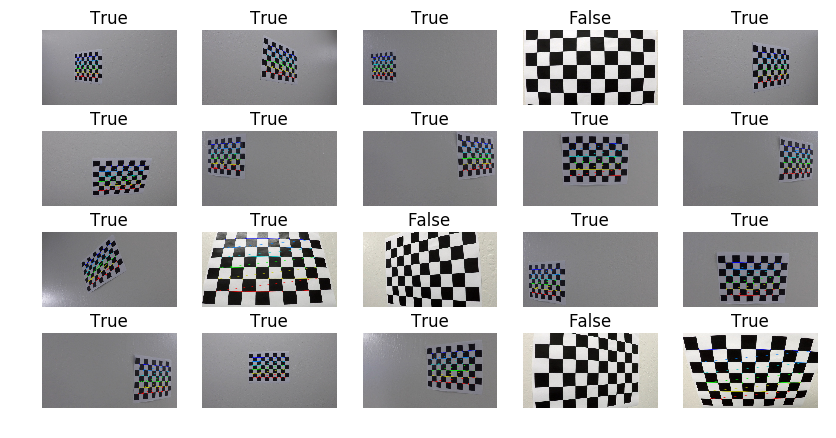

In [7]:
def camera_calibration(calibration_files, nx, ny):
    # Arrays to store object points and image points from all the images
    objpoints = [] #3D points in real world space
    imgpoints = [] #2D points in image plane

    #Prepare object points, like (0,0,0), (1, 0,0)
    objp = np.zeros((nx * ny, 3), np.float32)
    objp[:,:2] = np.mgrid[0:nx,0:ny].T.reshape(-1,2) #x, y coordinate

    _, ax = plt.subplots(int(np.ceil(len(calibration_files)/5)), 5, figsize=(10,5))
    row, col = [0, 0]
    for img_adress in calibration_files:
        #Convert chessboard image form RGB to gray
        img = cv2.imread(img_adress)
        img = cv2.cvtColor(img, cv2.COLOR_BGR2RGB)
        gray = cv2.cvtColor(img, cv2.COLOR_RGB2GRAY)
        # Find the chessboard corners
        ret, corners = cv2.findChessboardCorners(gray, (nx, ny), None)
        #Draw corners
        if ret:
            imgpoints.append(corners)
            objpoints.append(objp)
            img = cv2.drawChessboardCorners(img, (nx, ny), corners, ret)
        ax[row, col].imshow(img)
        ax[row,col].set_axis_off()
        ax[row, col].set_title(ret)
        if col==4:
            row = row + 1
            col = 0
        else:
            col = col + 1

    plt.show()

    # Image calibration: mtx
    #calibrateCamera(objectpoints, imagepoints, shape of image)
    #return camera matrix (mtx), distorsion coefficient (dist), 
    # position of the camera in the world: rvecs (rotation and translation vectors)
    return cv2.calibrateCamera(objpoints, imgpoints, gray.shape[::-1], None, None)


nx = 9 #number of corners in a row
ny = 6 #numbers or corners in a column
calibration_files = glob.glob('camera_cal/*.jpg')
assert len(calibration_files) > 0, 'No image calibration file could be found'
ret, mtx, dist, rvecs, tvecs = camera_calibration(calibration_files, nx, ny)

In [8]:

def directional_gradient(img, direction='x', ksize=3, thresh=[0, 255] ):
    #convert image to gray scale
    if len(img.shape) == 3:
        gray = cv2.cvtColor(img, cv2.COLOR_RGB2GRAY)
    else:
        gray = img
    #Get gradient along direction
    if direction == 'x':
        sobel = cv2.Sobel(gray, cv2.CV_64F, 1,0, ksize)
    elif direction == 'y':
        sobel = cv2.Sobel(gray, cv2.CV_64F, 0, 1, ksize)
    #Take absolute value
    sobel_abs = np.absolute(sobel)
    #turn sobel to 8bit image 0-255 intensity range
    scaled_sobel = np.uint8(sobel_abs * 255/np.max(sobel_abs))
    #binary
    binary_output = np.zeros_like(sobel)
    binary_output[(scaled_sobel>= thresh[0]) & (scaled_sobel <= thresh[1]) ] = 1
    return binary_output


def mag_gradient(img, thresh=[0, 255], ksize=3):
    #convert image to gray scale
    gray = cv2.cvtColor(img, cv2.COLOR_RGB2GRAY)
    #Get gradient along direction
    sobelx = cv2.Sobel(gray, cv2.CV_64F, 1,0, ksize)
    sobely = cv2.Sobel(gray, cv2.CV_64F, 0, 1, ksize)
    #Take absolute value
    gradient_mag = np.sqrt( np.square(sobelx) + np.square(sobely))
    #turn sobel to 8bit image 0-255 intensity range
    scaled_gradient_mag = np.uint8(gradient_mag * 255/np.max(gradient_mag))
    #binary
    binary_output = np.zeros_like(gradient_mag)
    binary_output[(scaled_gradient_mag>= thresh[0]) & (scaled_gradient_mag <= thresh[1]) ] = 1
    return binary_output


def gradient_direction(img, thresh=[0, np.pi/2], ksize=3):
    #convert image to gray scale
    if len(img.shape) == 3:
        gray = cv2.cvtColor(img, cv2.COLOR_RGB2GRAY)
    else:
        gray = img
    #Get gradient along direction
    sobelx = cv2.Sobel(gray, cv2.CV_64F, 1,0, ksize)
    sobely = cv2.Sobel(gray, cv2.CV_64F, 0, 1, ksize)
    #Take absolute value
    gradient_dir = np.arctan2( sobely, sobelx)
    #turn sobel to 8bit image 0-255 intensity range
    #binary
    binary_output = np.zeros_like(gradient_dir)
    binary_output[(gradient_dir>= thresh[0]) & (gradient_dir <= thresh[1]) ] = 1
    return binary_output


def color_binary(img, dst_format, ch1_thresh=[1, 0,255], ch2_thresh=[0,255]):
    assert len(img.shape) == 3, 'img does not have 3 color channels'
    if dst_format == 'HLS':
        img = cv2.cvtColor(img, cv2.COLOR_RGB2HLS)
    else:
        img = cv2.cvtColor(img, cv2.COLOR_RGB2HSV)
    ch1_binary = np.zeros_like(img[:,:,1])
    ch1_binary[(img[:,:,1] >= ch1_thresh[0]) & (img[:,:,1]<= ch1_thresh[1])] = 1
    ch2_binary = np.zeros_like(img[:,:,2])
    ch2_binary[(img[:,:,2] >= ch2_thresh[0]) & (img[:,:,2]<= ch2_thresh[1])] = 1
    combined = np.zeros_like(img[:,:,1])
    combined[(ch1_binary==1) & (ch2_binary==1)] = 1
    return combined

def warp(img, src, dst):
    M = cv2.getPerspectiveTransform(src, dst)
    img_sz = (img.shape[1], img.shape[0])
    img_warped = cv2.warpPerspective(img, M, img_sz, flags=cv2.INTER_LINEAR)
    return img_warped

# Determine window coordinate

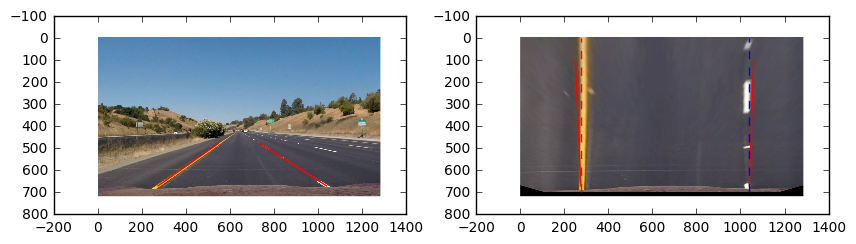

In [9]:
src_pts = np.float32([[250, 680], [545, 480], [730, 480], [1060, 680]])
dst_pts = np.float32([[250, 680], [250, 100], [1060, 100], [1060, 680]])

img = cv2.imread(imgs_lane[1])
img = cv2.cvtColor(img, cv2.COLOR_BGR2RGB)
#Undistort image using camera calibration correction

camera_corr = {'ret':ret, 'mtx':mtx, 'dist':dist, 'rvecs':rvecs, 'tvecs':tvecs}

img_dst = cv2.undistort(img, camera_corr['mtx'], camera_corr['dist'], None, camera_corr['mtx'])
# Warp image
#select points on 2D image: source points
src_pts = np.float32([[275, 670], [545, 480], [740, 480], [1040, 670]])
dst_pts = np.float32([[275, 670], [250, 100], [1060, 100], [1040, 670]])
img_warped = warp(img_dst, src_pts, dst_pts)


_, ax = plt.subplots(1, 2, figsize=(10, 5))
ax[0].imshow(img)
ax[0].plot([src_pts[0][0], src_pts[1][0]], [src_pts[0][1], src_pts[1][1]], 'r-')
ax[0].plot([src_pts[2][0], src_pts[3][0]], [src_pts[2][1], src_pts[3][1]], 'r-')
ax[1].imshow(img_warped, cmap='gray')
ax[1].plot([dst_pts[0][0], dst_pts[1][0]], [dst_pts[0][1], dst_pts[1][1]], 'r-')
ax[1].plot([dst_pts[2][0], dst_pts[3][0]], [dst_pts[2][1], dst_pts[3][1]], 'r-')
ax[1].plot([275, 275], [700, 0], 'r--')
ax[1].plot([1040, 1040], [700, 0], 'b--')
plt.show()

# Pipeline step by step

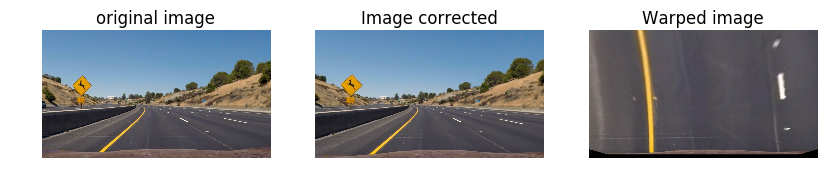

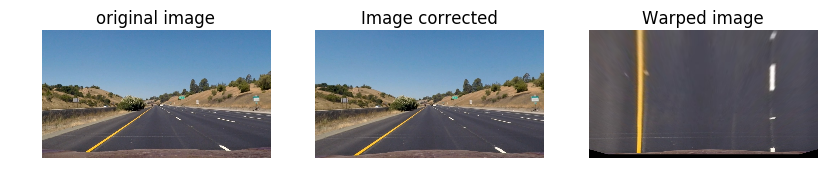

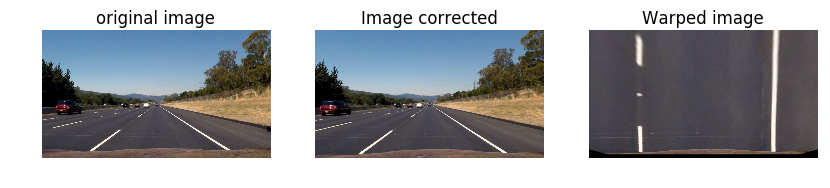

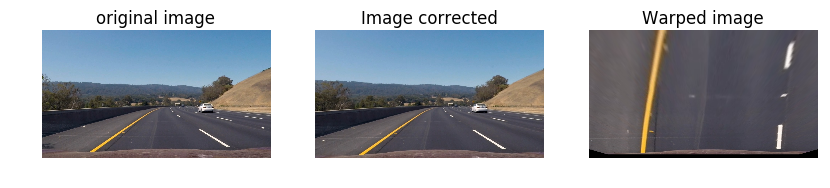

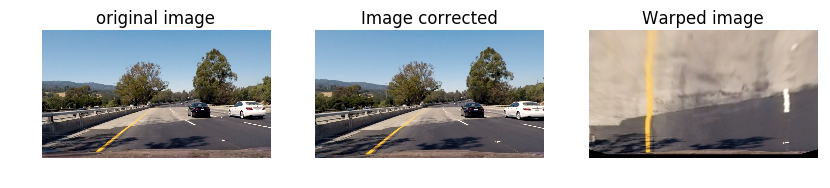

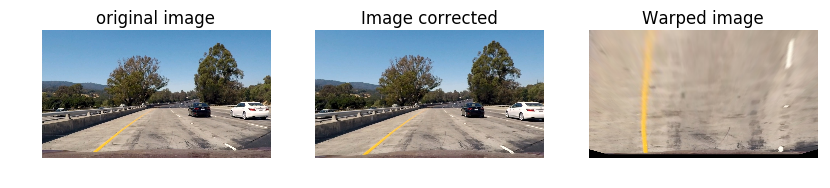

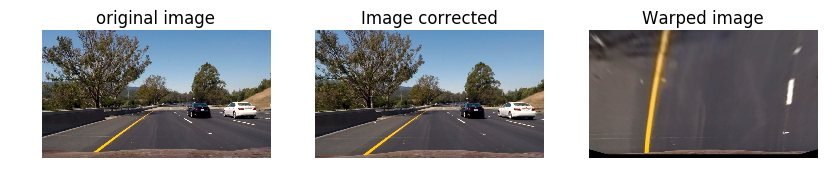

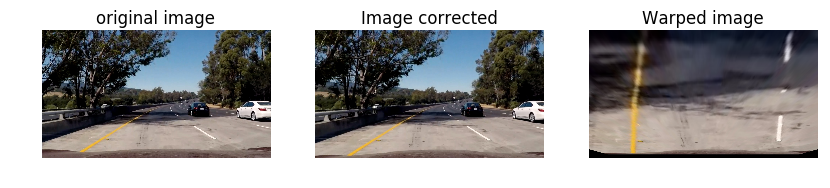

In [10]:

def pipeline(img_adress, camera_corr, display=0):
    #Load original image
    img = cv2.imread(img_adress)
    img = cv2.cvtColor(img, cv2.COLOR_BGR2RGB)
    #Undistort image using camera calibration correction
    img_dst = cv2.undistort(img, camera_corr['mtx'], camera_corr['dist'], None, camera_corr['mtx'])
    # Warp image
    #select points on 2D image: source points
    src_pts = np.float32([[275, 670], [545, 480], [740, 480], [1040, 670]])
    dst_pts = np.float32([[275, 670], [250, 100], [1060, 100], [1040, 670]])
    
    img_warped = warp(img_dst, src_pts, dst_pts)
    if display:
        _, ax = plt.subplots(1, 3, figsize=(10,5))
        ax[0].imshow(img)
        ax[0].set_title('original image')
        ax[0].axis('off')
        ax[1].imshow(img_dst)
        ax[1].set_title('Image corrected')
        ax[1].axis('off')
        ax[2].imshow(img_warped)
        ax[2].set_title('Warped image')
        ax[2].axis('off')
        plt.show()

    return img_warped 

        
imgs_lane = glob.glob('test_images/*.jpg')
for img_adress in imgs_lane:
    img_warped = pipeline(img_adress, camera_corr, display=1)

In [11]:
def optimum_threshold(binary_img, operator_name, k_size, windows, step):
    #record signal, noise
    log= []
    best_param = []
    noise = binary_img.shape[0] * binary_img.shape[1] #assumes image is made of white pixels only
    signal = 0
    for thresh_lo in range(0, 255, step):
        for thresh_hi in range(thresh_lo+step, 255+step, step):
            assert operator_name in ('gradx', 'grady', 'gradient_mag', 'gradient_dir'), 'operator name not found'
            if operator_name == 'gradx':
                operator = directional_gradient(binary_img, direction='x', ksize=5, thresh=[thresh_lo, thresh_hi] ) #10, 100
            elif operator_name == 'grady':
                operator = directional_gradient(binary_img, direction='y', ksize=5, thresh=[thresh_lo, thresh_hi] ) #10, 100
        
            #get histogram
            histogram = np.sum(operator, axis=0)
            #signal is the integral of the histogram: i.e the area under the curve
            this_signal = np.sum(histogram[windows[0][0] : windows[0][1]]) +\
             np.sum(histogram[windows[1][0] : windows[1][1]])
            #noise signal : signal outside the windows must be minimal
            this_noise = np.sum(histogram) - this_signal
            #condition to optimize threshold values
            if (this_signal - this_noise) > (signal - noise): #need to find a better condition
                best_param=[thresh_lo, thresh_hi, this_signal, this_noise]
                signal, noise = this_signal, this_noise
            log.append([thresh_lo, thresh_hi, this_signal, this_noise])
    return (best_param, log)

test_images/test2.jpg


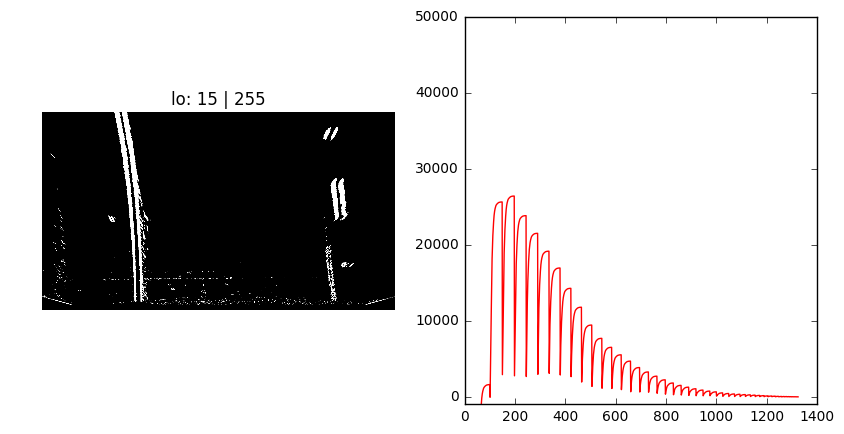

test_images/straight_lines1.jpg


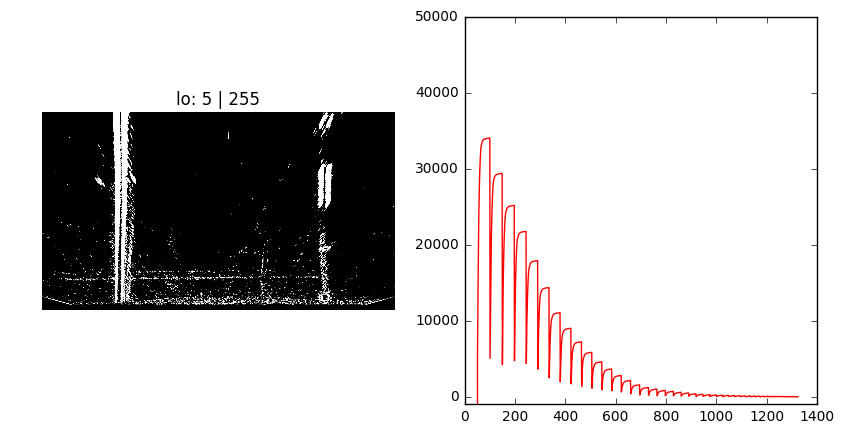

test_images/straight_lines2.jpg


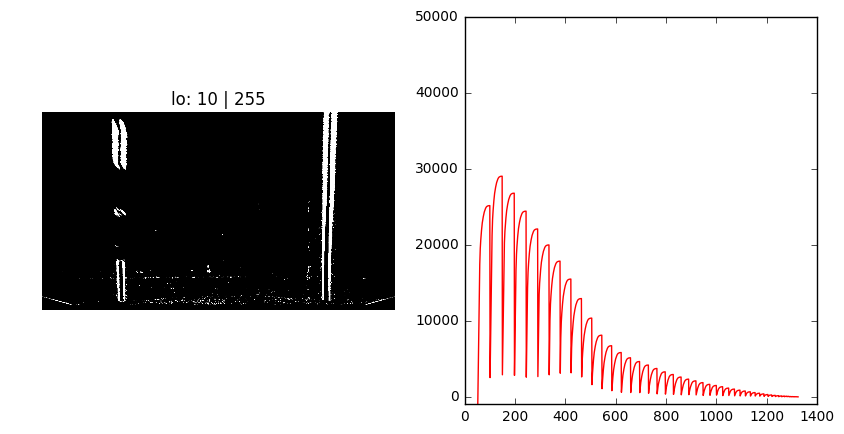

test_images/test3.jpg


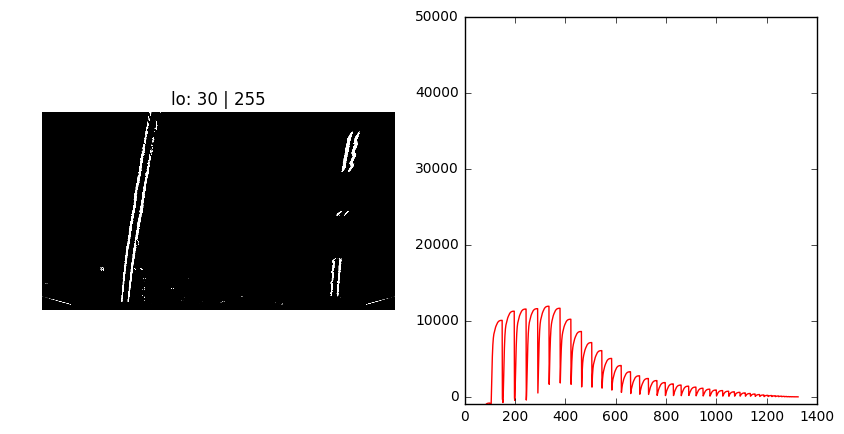

test_images/test4.jpg


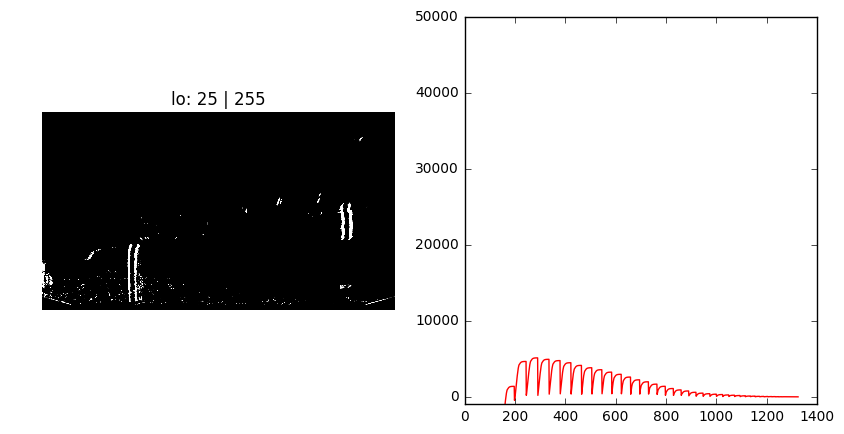

test_images/test1.jpg


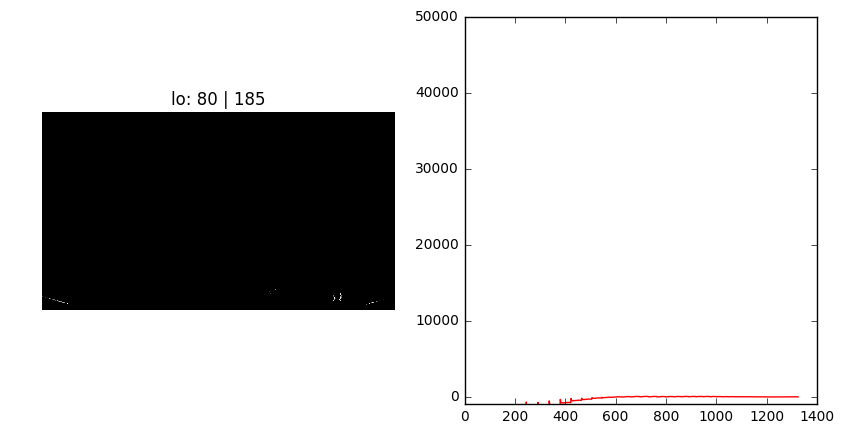

test_images/test6.jpg


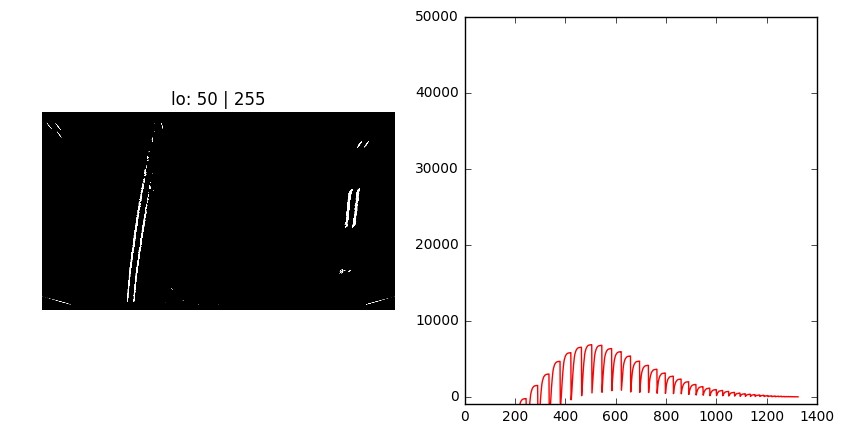

test_images/test5.jpg


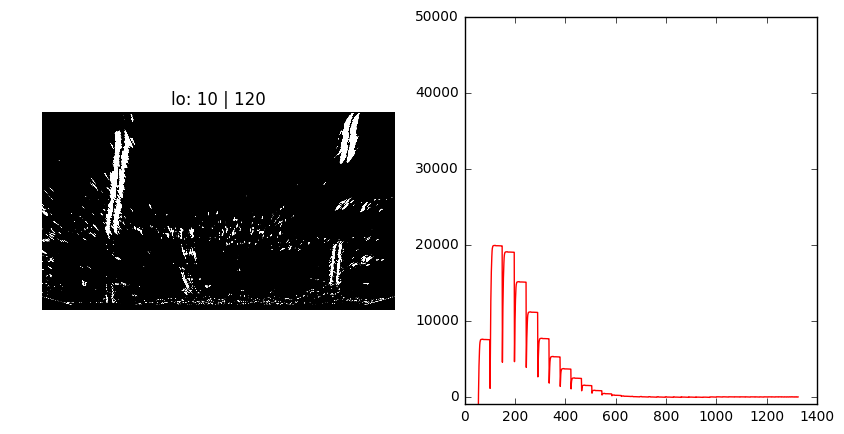

[[15, 255, 30575.0, 4147.0], [5, 255, 48144.0, 14080.0], [10, 255, 32048.0, 3006.0], [30, 255, 14740.0, 2814.0], [25, 255, 8443.0, 3314.0], [80, 185, 212.0, 150.0], [50, 255, 8496.0, 1632.0], [10, 120, 32639.0, 12708.0]]


In [12]:
windows = [[200, 370],[1000,1260]]  
step = 5
k_size = 5

thresh_rec = []

for img_adress in imgs_lane:
    print(img_adress)
    img_warped = pipeline(img_adress, camera_corr, display=0)
    best_param, log = optimum_threshold(img_warped, 'gradx', k_size, windows, step)
    thresh_rec.append(best_param)
    gradx = directional_gradient(img_warped, direction='x', ksize=5, thresh=[best_param[0], best_param[1]] )
    _, ax = plt.subplots(1, 2, figsize=(10,5))
    ax[0].imshow(gradx, cmap='gray')
    ax[0].set_title('lo: '+ str(best_param[0]) +' | '+ str(best_param[1]) )
    ax[0].axis('off')
    log = np.array(log)
    ax[1].plot(np.arange(0, len(log), 1), log[:,2] - log[:,3], 'r')
    ax[1].set_ylim([-1000,50000])
    plt.show()
print(thresh_rec)

test_images/test1.jpg


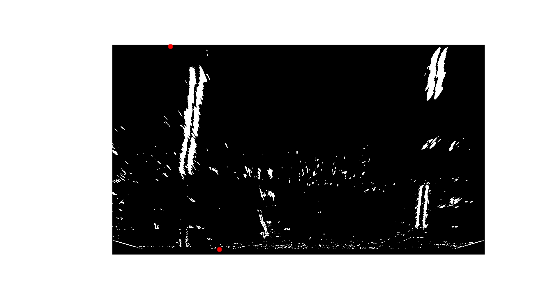

In [13]:
img_a = imgs_lane[5]
print(img_a)
img_warped = pipeline(img_adress, camera_corr, display=0)
gradx = directional_gradient(img_warped, direction='x', ksize=5, thresh=[12, 255] )
windows = [[250, 370],[1000,1260]]  
plt.imshow(gradx, cmap='gray')
plt.plot(200, 0, 'r.')
plt.plot(370, 700, 'r.')
plt.axis('off')
plt.show()

# update pipeline
# adding Gradx

test_images/test1.jpg


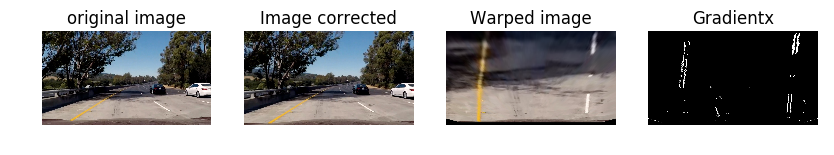

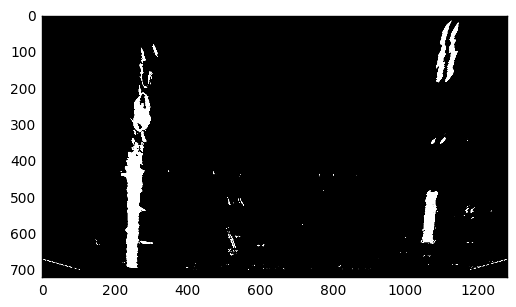

In [14]:
def pipeline(img_adress, camera_corr, display=0):
    #Load original image
    img = cv2.imread(img_adress)
    img = cv2.cvtColor(img, cv2.COLOR_BGR2RGB)
    #Undistort image using camera calibration correction
    img_dst = cv2.undistort(img, camera_corr['mtx'], camera_corr['dist'], None, camera_corr['mtx'])
    # Warp image
    #select points on 2D image: source points
    src_pts = np.float32([[275, 670], [545, 480], [740, 480], [1040, 670]])
    dst_pts = np.float32([[275, 670], [250, 100], [1060, 100], [1040, 670]])
    
    img_warped = warp(img_dst, src_pts, dst_pts)
    
    #apply x gradient operator
    gradx = directional_gradient(img_warped, direction='x', ksize=5, thresh=[25, 255] ) #10, 100
    grady = directional_gradient(img_warped, direction='x', ksize=5, thresh=[25, 255] )
    ls_binary = color_binary(img_warped, 'HLS', ch1_thresh=[100,255], ch2_thresh=[120,255])
    sv_binary = color_binary(img_warped, 'HSV', ch1_thresh=[110,255], ch2_thresh=[120,255])
    grad_mag = mag_gradient(img_warped, thresh=[10, 255], ksize=3)
    grad_dir = gradient_direction(img_warped, thresh=[0.7, 1.4], ksize=3)
    final_binary = np.zeros_like(ls_binary)
    final_binary[((gradx==1) & (grady==1))|((sv_binary==1))|(ls_binary==1)] = 1
    if display:
        _, ax = plt.subplots(1, 4, figsize=(10,5))
        ax[0].imshow(img)
        ax[0].set_title('original image')
        ax[0].axis('off')
        ax[1].imshow(img_dst)
        ax[1].set_title('Image corrected')
        ax[1].axis('off')
        ax[2].imshow(img_warped, cmap='gray')
        ax[2].set_title('Warped image')
        ax[2].axis('off')
        ax[3].imshow(gradx, cmap='gray')
        ax[3].set_title('Gradientx')
        ax[3].axis('off')
        plt.show()

    return final_binary

img_a = imgs_lane[5]
print(img_a)
img_gradx = pipeline(img_adress, camera_corr, display=1)
plt.imshow(img_gradx, cmap='gray')
#plt.axis('off')
plt.show()

# This startegy : save only the centroid

640


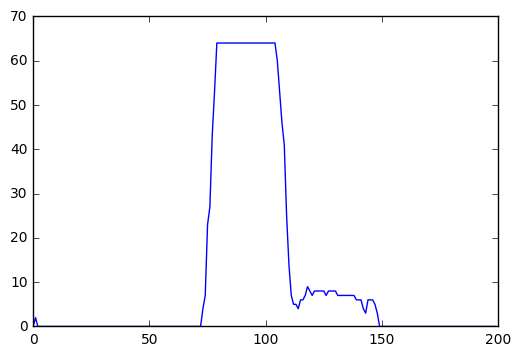

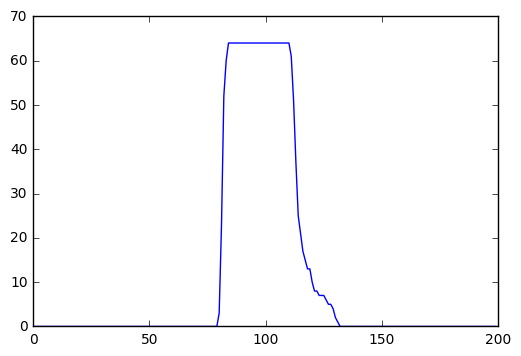

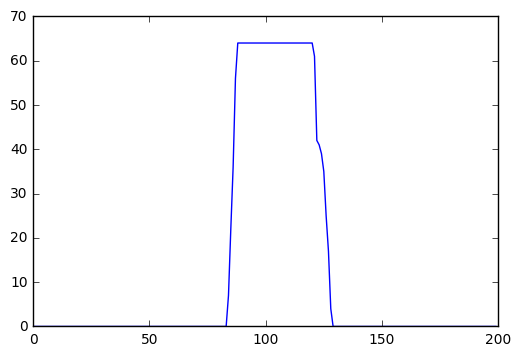

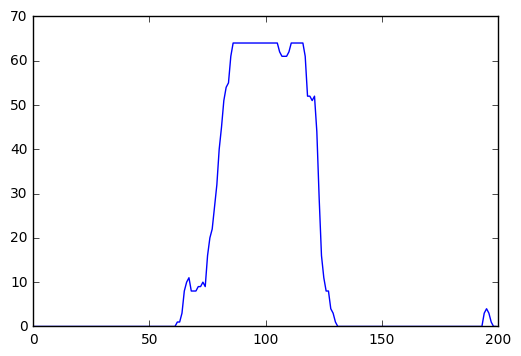

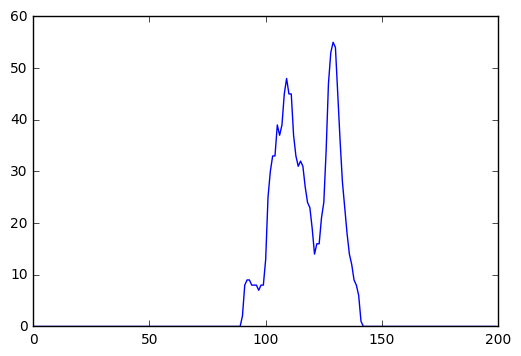

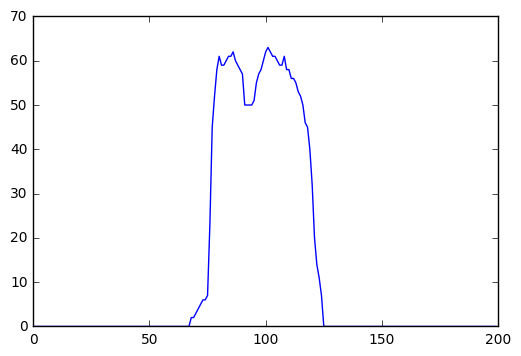

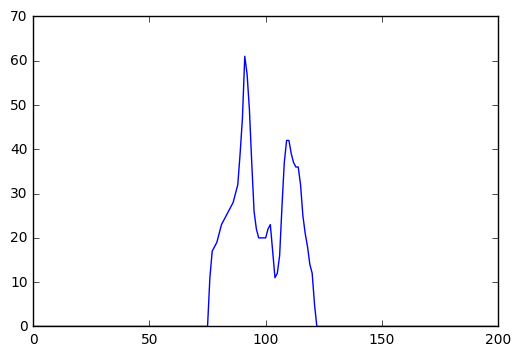

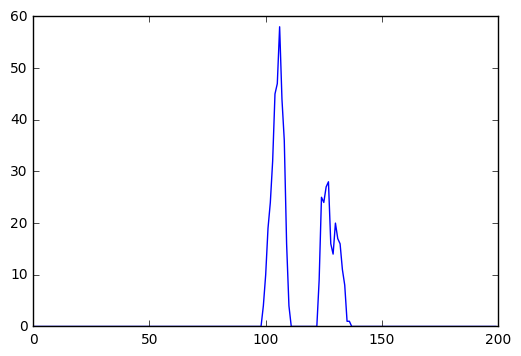

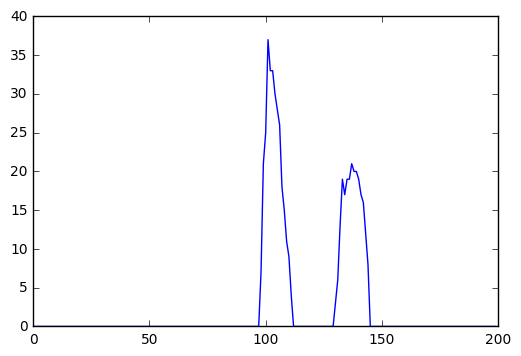

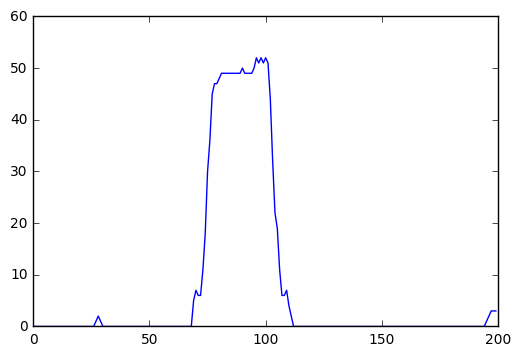

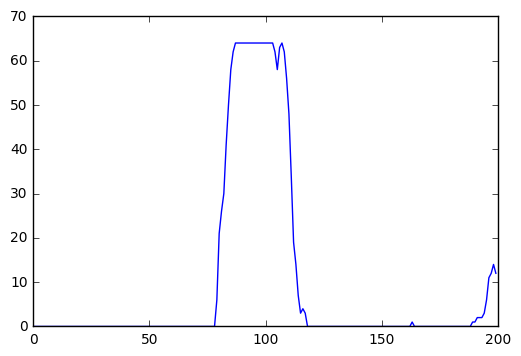

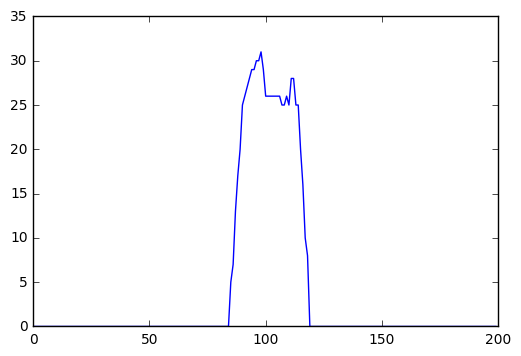

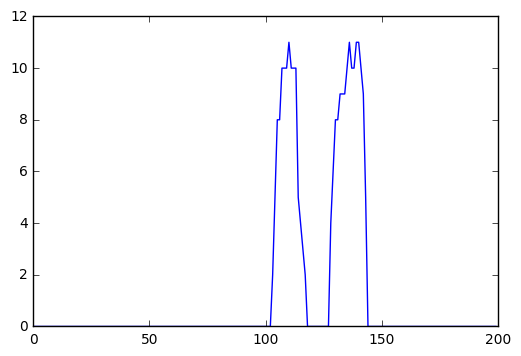

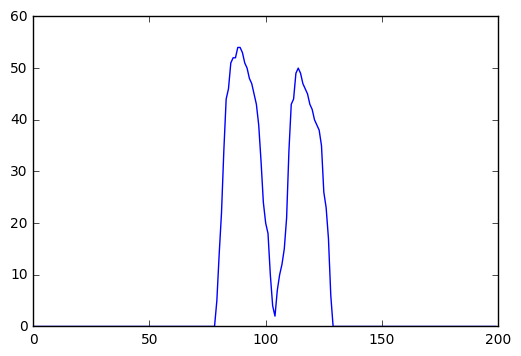

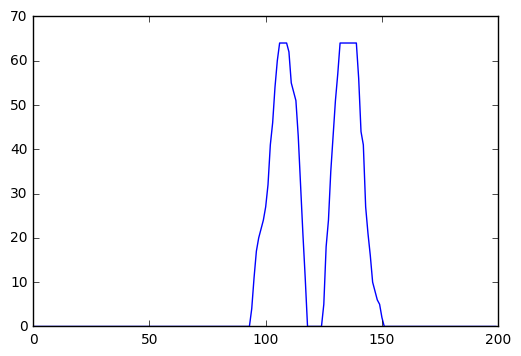

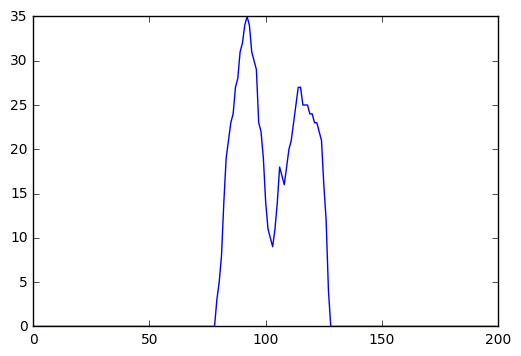

In [15]:
import matplotlib.patches as patches

class frame_process(object):
    
    
    def __init__(self, image, image_height, sliding_window, n_histogram_peaks, hot_pixel_thresh):
        self.image = image
        self.sliding_window = sliding_window
        self.image_height = image_height
        self.n_histogram_peaks = n_histogram_peaks
        self.hot_pixel_thresh = hot_pixel_thresh
    
    def find_starter_centroid(self, position):
        assert position in ('left', 'right'), 'position value can only be: left or right'
        if position == 'left':
            #define the window (half left bottom of image)
            x0, window_width, y0, window_height = 0, int(self.image.shape[1]/2), self.image_height,\
                                                  int(self.image_height/2) 

            #only interested in rough estimate of the line
            centroid, _ = self.find_centroid(self.image, x0, window_width, y0, window_height)
            
        elif position == 'right':
            #define the window (half right bottom of image)
            x0, window_width, y0, window_height = int(self.image.shape[1]/2), int(self.image.shape[1]/2), \
                                                    self.image_height, int(self.image_height/2) 
            #only interested in rough estimate of the line
            centroid, _ = self.find_centroid(self.image, x0, window_width, y0, window_height)
        return centroid

    
    
    def find_centroid(self, img, x0, window_width, y0, window_height, display=0):
        #take histogram of part of image
        #crop image - convert all elements to integer
        crop_image = img[ int(y0-window_height):int(y0), int(x0):int(x0+ window_width)]
        
        histogram = np.sum(crop_image, axis=0)
        hot_pixel_cnt = np.sum(histogram)
        if hot_pixel_cnt > self.hot_pixel_thresh:
            centroids = np.argsort(histogram)[-self.n_histogram_peaks:]
            centroid = np.mean(centroids)
            if display:
                plt.plot(histogram)
                plt.show() 
            centroid = int(centroid + x0)
        else:
            centroid = x0 + int(window_width/2) #
            
        return (centroid, hot_pixel_cnt)   
    
    
    
    def run_sliding_window(self, centroid_starter, centroid_type):
        x0 = centroid_starter - int(self.sliding_window['width']/2)
        y0 = self.image_height
        centroid_log = []
        for step in range(n_steps):
            centroid, centroid_weight  = self.find_centroid(self.image,
                                                            x0,
                                                            self.sliding_window['width'],
                                                            y0,
                                                            self.sliding_window['height'],
                                                            display=1)
            centroid_log.append([centroid, int(y0-self.sliding_window['height']), centroid_weight])
            x0 = int(centroid - self.sliding_window['width']/2)
            y0 = y0 - self.sliding_window['height']
        
        return centroid_log
    
    
bottom_crop = 80
img_height, img_width = img_gradx.shape
img_height = img_height - bottom_crop #Take off
print(img_height)
n_steps = 10 #number of steps vertical steps of sliding window
sliding_window = {'width': 200, 'height': int(img_height/n_steps), 'n_steps': n_steps}
n_histogram_peaks = 3
centroid_type = 'all_hot_pixel'  #single_point
hot_pixel_thresh = 50

new_frame = frame_process(img_gradx, img_height, sliding_window, n_histogram_peaks, hot_pixel_thresh)
centroid_starter_left = new_frame.find_starter_centroid('left')
centroid_starter_right = new_frame.find_starter_centroid('right')

leftLane_log = new_frame.run_sliding_window(centroid_starter_left, centroid_type)
rightLane_log = new_frame.run_sliding_window(centroid_starter_right, centroid_type)
leftLane_log = np.array(leftLane_log)
rightLane_log = np.array(rightLane_log)
leftLane_log0 = leftLane_log
rightLane_log0 = rightLane_log
#centroid_starter_left, centroid_starter_right = new_frame.find_centroid_starter(display=1)

#centroid_starter_left, centroid_starter_right = new_frame.find_centroid_starter(display=1)

# Let's look at the centroid

Left Lane log tabe |centroid_x | centroid_y | nbr of pixels in window: 
 [[  253.   576.  2312.]
 [  248.   512.  2189.]
 [  252.   448.  2497.]
 [  246.   384.  2892.]
 [  275.   320.  1298.]
 [  276.   256.  2552.]
 [  268.   192.  1243.]
 [  273.   128.   556.]
 [  275.    64.   526.]
 [  275.     0.     0.]]


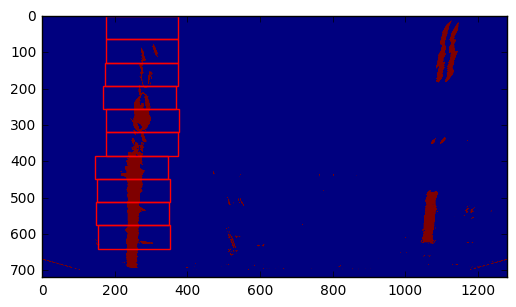

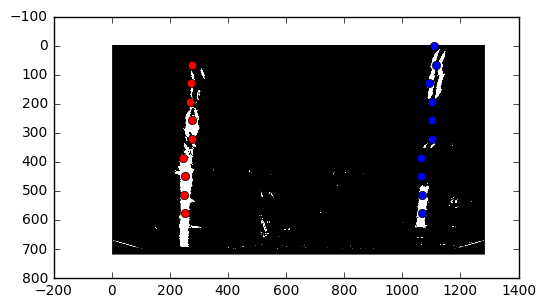

In [16]:
#from numpy.polynomial import polynomial as P

print('Left Lane log tabe |centroid_x | centroid_y | nbr of pixels in window: \n {}'.format(leftLane_log0) )
#clean up the logs by removing all points were the hot_pixel_thresh = 50 was not met
leftLane_log = leftLane_log[leftLane_log[:,2] > hot_pixel_thresh]
leftLane_log = leftLane_log[leftLane_log[:,2] > hot_pixel_thresh]

#first find the 2 starting positions for the left and right lane by
window_width = sliding_window['width']
n_steps = sliding_window['n_steps']
window_height = sliding_window['height']
fig,ax = plt.subplots(1)
ax.imshow(img_gradx)
for step in range(n_steps):
    # Create a Rectangle patch
    window_x0 = int( leftLane_log0[step, 0] - window_width/2)
    window_y0 = leftLane_log0[step, 1]
    rect = patches.Rectangle((window_x0,window_y0),window_width,window_height,linewidth=1,edgecolor='r',facecolor='none')
        # Add the patch to the Axes
    ax.add_patch(rect)
plt.show()

plt.imshow(img_gradx, cmap='gray')
plt.plot(leftLane_log[:,0], leftLane_log[:,1], 'ro')
plt.plot(rightLane_log[:,0], rightLane_log[:,1], 'bo')
plt.show()

# Fit centroids to order 2 polynomial

Left polyfit coefficients - a0: 279.595238095238 | a1: -0.041176271645020836 | a2: -2.721480992965537e-05
[ 253.  248.  252.  246.  275.  276.  268.  273.  275.  275.]
[ 279.5952381   235.84016504]


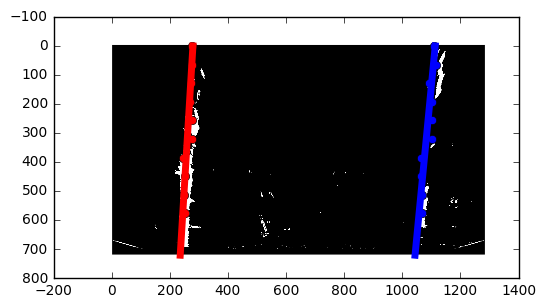

In [17]:
# a0 + a1 x + a2 x**2
a2_left, a1_left, a0_left = np.polyfit(leftLane_log[:,1], leftLane_log[:,0], 2)
a2_right, a1_right, a0_right = np.polyfit(rightLane_log[:,1], rightLane_log[:,0], 2)

print('Left polyfit coefficients - a0: {} | a1: {} | a2: {}'.format(a0_left, a1_left, a2_left))

#show fit in image
# get min and maximum
#Instead of fit y=f(x) we will fit x = f(y) where y is the height
h_pts = np.array([0, img_gradx.shape[0]])

leftLane_fit = a2_left*h_pts**2 + a1_left*h_pts + a0_left
rightLane_fit = a2_right*h_pts**2 + a1_right*h_pts + a0_right

plt.imshow(img_gradx, cmap='gray')

plt.plot(leftLane_log0[:,0], leftLane_log0[:,1], 'ro')
plt.plot(rightLane_log0[:,0], rightLane_log0[:,1], 'bo')
print(leftLane_log0[:,0])
print(leftLane_fit)
plt.plot(leftLane_fit, h_pts, 'r-', linewidth=5)
plt.plot(rightLane_fit, h_pts, 'b-', linewidth=5)
plt.show()

# Need to work out some imporvements:
remove points where the hot_pixel +_threshold not met for fitting data

(720, 1280)


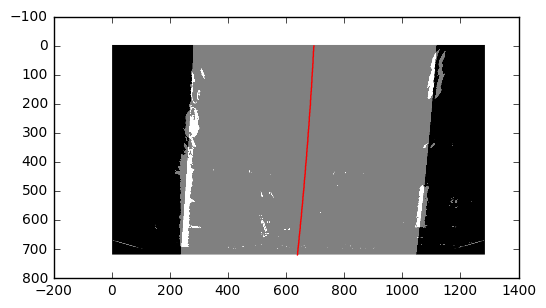

In [18]:
pred_lanes = np.zeros_like( img_gradx, dtype='uint8')
print(pred_lanes.shape)
h_pts_ = np.linspace(0, 719, num=720)#
h_pts_ = h_pts_.astype(int)
left_pred = a2_left*h_pts_**2 + a1_left*h_pts_ + a0_left
left_pred = left_pred.astype(int)
right_pred = a2_right*h_pts_**2 + a1_right*h_pts_ + a0_right
right_pred = right_pred.astype(int)
draw_type = 'fillpoly'
#cv2.fillPoly(pred_lanes, [left_pred, h_pts_], color=[255, 0, 0])
if draw_type == 'lines':
    pred_lanes[ [ h_pts_, left_pred ] ]= 1
    pred_lanes[ [ h_pts_, right_pred ] ]= 1

elif draw_type == 'fillpoly':
    points_l = list(zip(left_pred, h_pts_))
    h_pts_ = np.linspace(719, 0, num=720)
    h_pts_ = h_pts_.astype(int)
    right_pred = a2_right*h_pts_**2 + a1_right*h_pts_ + a0_right
    right_pred = right_pred.astype(int)
    points_r = np.array(list(zip(right_pred, h_pts_)))
    points = np.concatenate( [points_l, points_r] )
    cv2.fillPoly(pred_lanes, [points], (1,0,0))

#Draw the center line
h_pts_ = np.linspace(0, 719, num=720)#
right_pred = a2_right*h_pts_**2 + a1_right*h_pts_ + a0_right
center_line_x = (left_pred + right_pred)/2
center_line_x = center_line_x.astype(int)


camera_center = right_pred
#plt.imshow(pred_lanes, cmap='gray')
res = cv2.addWeighted(img_gradx, 0.8, pred_lanes, 1, 0.0)
#plt.imshow(pred_lanes)
plt.imshow(res, cmap='gray')
plt.plot(center_line_x, h_pts_, 'r-')

# Unwarp image

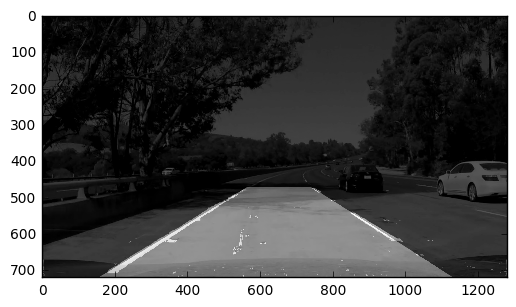

In [19]:
Minv = cv2.getPerspectiveTransform(dst_pts, src_pts)
res_unwarp = cv2.warpPerspective(res, Minv, (res.shape[1], res.shape[0]), flags=cv2.INTER_LINEAR )
original = cv2.imread(img_adress)
original = cv2.cvtColor(original, cv2.COLOR_BGR2GRAY)
#final = cv2.addWeighted( res_unwarp, 0.5,original, 1, 0.0)
final = res_unwarp + original/255
plt.imshow(final, cmap='gray')

# Compile all code 

In [20]:
import numpy as np
import cv2
import glob
import matplotlib.pyplot as plt
%matplotlib inline

In [21]:
class Camera_calibration():
    
    def __init__(self, calibration_files, nx, ny):
        self.nx = nx
        self.ny = ny
        self.calibration_files = calibration_files
        
    def find_corners(self, display=0):
        # Arrays to store object points and image points from all the images
        objpoints = [] #3D points in real world space
        imgpoints = [] #2D points in image plane
        #Prepare object points, like (0,0,0), (1, 0,0)
        objp = np.zeros((nx * ny, 3), np.float32)
        objp[:,:2] = np.mgrid[0:nx,0:ny].T.reshape(-1,2) #x, y coordinate
        for cal_file in self.calibration_files:
            #Convert chessboard image form RGB to gray
            cal_img = cv2.imread(cal_file)
            cal_img = cv2.cvtColor(cal_img, cv2.COLOR_BGR2RGB)
            cal_gray = cv2.cvtColor(cal_img, cv2.COLOR_RGB2GRAY) 
            ret, corners = cv2.findChessboardCorners(cal_gray, (self.nx, self.ny), None)
            #Draw corners
            if ret:
                imgpoints.append(corners)
                objpoints.append(objp)
                draw_corners = cv2.drawChessboardCorners(cal_img, (nx, ny), corners, ret)
                img_sz = cal_gray.shape[::-1]
        return {'ret': ret, 'imagePoints': imgpoints , 'objectPoints': objpoints, 'img_sz': img_sz }

    
    def run_calibration(self, corners):
        # Image calibration: mtx
        #calibrateCamera(objectpoints, imagepoints, shape of image)
        #return camera matrix (mtx), distorsion coefficient (dist), 
        # position of the camera in the world: rvecs (rotation and translation vectors)
        assert corners['ret']==True, 'Camera calibration fails' 
        if corners['ret']:
            objpoints = corners['objectPoints']
            imgpoints = corners['imagePoints']
            img_sz = corners['img_sz']
            ret, mtx, dist, rvecs, tvecs = cv2.calibrateCamera(objpoints, imgpoints, img_sz, None, None)
            return {'ret': ret, 'cameraMatrix': mtx, 'distorsionCoeff': dist, \
                    'rotationVec': rvecs, 'translationVec': tvecs}

    
    
nx = 9 #number of corners in a row
ny = 6 #numbers or corners in a column
imgs_calibration = glob.glob("camera_cal/calibration*.jpg") #list of chessboard image file
assert len(imgs_calibration) >= 1, 'No calibration files in folder'
cameraCal =  Camera_calibration(imgs_calibration, nx, ny)
corners = cameraCal.find_corners()
cal_params = cameraCal.run_calibration(corners)
# for a good calibration ret must be between 0.1 and 1.0
print('RMS Error of Camera calibration: {:.3f}'.format(cal_params['ret']) )

RMS Error of Camera calibration: 1.030


# Check image correction

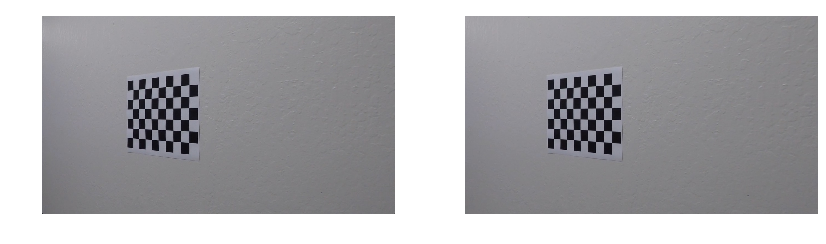

In [22]:
rand_pick = np.random.choice(imgs_calibration)
img = cv2.imread(rand_pick)
img = cv2.cvtColor(img, cv2.COLOR_BGR2RGB)

dst = cv2.undistort(img, cal_params['cameraMatrix'], \
                            cal_params['distorsionCoeff'], None, \
                            cal_params['cameraMatrix'])

_, ax = plt.subplots(1,2, figsize=(10,5))    
ax[0].imshow(img)
ax[0].axis('off')
ax[1].imshow(dst)
ax[1].axis('off')
plt.show()

# Image Process

In [23]:
class Image_process():
    
    def __init__(self):
        print('Initialization')
        
    def image_correction(self, img, cal_parameters):
        dst = cv2.undistort(img, cal_parameters['cameraMatrix'], \
                            cal_parameters['distorsionCoeff'], None, \
                            cal_parameters['cameraMatrix'])
        return dst
    
    def convert2_rgb(self, img):
        assert (len(img.shape) == 3), 'cannot be converted to RGB'
        rgb = cv2.cvtColor(img, cv2.COLOR_BGR2RGB)
        return rgb
        
        
    def convert2_gray(self, img):
        assert (len(img.shape) == 3 or len(simg.shape) == 1), \
                                    'cannot be converted to grayscale. Image must have 1 or 3 color channels'
        if len(img.shape) == 3:
            gray = cv2.cvtColor(img, cv2.COLOR_RGB2GRAY)
            return gray
        
        elif len(img.shape) == 1:
            return img

    
    def directional_gradient(self, img, direction='x', thresh=[0, 255],  ksize=3 ):
        #convert image to grayscale
        gray = self.convert2_gray(img)
        #Get gradient along direction
        if direction == 'x':
            sobel = cv2.Sobel(gray, cv2.CV_64F, 1,0, ksize)
        elif direction == 'y':
            sobel = cv2.Sobel(gray, cv2.CV_64F, 0,1, ksize)
        
        #Take absolute value
        sobel_abs = np.absolute(sobel)
        #turn sobel to 8bit image 0-255 intensity range
        scaled_sobel = np.uint8(sobel_abs * 255/np.max(sobel_abs))
        #make binary using pixel intensity threshold
        binary_output = np.zeros_like(sobel)
        binary_output[(scaled_sobel>= thresh[0]) & (scaled_sobel <= thresh[1]) ] = 1
        return binary_output


    def mag_gradient(self, img, thresh=[0, 255], ksize=3):
        #convert image to gray scale
        gray = self.convert2_gray(img)
        #Get gradient along x and y direction
        sobelx = cv2.Sobel(gray, cv2.CV_64F, 1,0, ksize)
        sobely = cv2.Sobel(gray, cv2.CV_64F, 0, 1, ksize)
        #Take absolute value
        gradient_mag = np.sqrt( np.square(sobelx) + np.square(sobely))
        #turn sobel to 8bit image 0-255 intensity range
        scaled_gradient_mag = np.uint8(gradient_mag * 255/np.max(gradient_mag))
        #binary using pixel intensity threshold
        binary_output = np.zeros_like(gradient_mag)
        binary_output[(scaled_gradient_mag >= thresh[0]) & (scaled_gradient_mag <= thresh[1]) ] = 1
        return binary_output


    def gradient_direction(self, img, thresh=[0, 90], ksize=3):
        #convert image to gray scale
        gray = self.convert2_gray(img)
        #Get gradient along direction
        sobelx = cv2.Sobel(gray, cv2.CV_64F, 1,0, ksize)
        sobely = cv2.Sobel(gray, cv2.CV_64F, 0, 1, ksize)
        #Take absolute value
        gradient_dir = np.arctan2( sobely, sobelx)
        #turn sobel to 8bit image 0-255 intensity range
        #convert threshold from degree to radian
        thresh = [thresh[0] * np.pi/180, thresh[1] * np.pi/180]
        #binary using pixel intensity threshold
        binary_output = np.zeros_like(gradient_dir)
        binary_output[(gradient_dir>= thresh[0]) & (gradient_dir <= thresh[1]) ] = 1
        return binary_output


    def hls_binary(self, chl_thresh=[0,255], chs_thresh=[0,255]):
        hls = cv2.cvtColor(self.image, cv2.COLOR_RGB2HLS)
        l_binary = np.zeros_like(hsl[:,:,1])
        l_binary[(hsl[:,:,1] >= chl_thresh[0]) & (hsl[:,:,1]<= chl_thresh[1])] = 1
        s_binary = np.zeros_like(hsl[:,:,2])
        s_binary[(hsl[:,:,2] >= 100) & (hsl[:,:,2]<= 255)] = 1
        binary_output = np.zeros_like(s_binary)
        binary_output[(l_binary==1) & (s_binary==1)] = 1
        return binary_output
    
    def color_binary(self, img, dst_format, ch2_thresh=[0,255], ch3_thresh=[0,255]):
        assert len(img.shape) == 3, 'img must have 3 color channels'
        if dst_format == 'HLS':
            img = cv2.cvtColor(img, cv2.COLOR_RGB2HLS)
        else:
            img = cv2.cvtColor(img, cv2.COLOR_RGB2HSV)
        ch2_binary = np.zeros_like(img[:,:,1])
        ch2_binary[(img[:,:,1] >= ch2_thresh[0]) & (img[:,:,1]<= ch2_thresh[1])] = 1
        ch3_binary = np.zeros_like(img[:,:,2])
        ch3_binary[(img[:,:,2] >= ch3_thresh[0]) & (img[:,:,2]<= ch3_thresh[1])] = 1
        combined_binary = np.zeros_like(img[:,:,1])
        combined_binary[(ch2_binary==1) & (ch3_binary==1)] = 1
        return combined_binary

    
    def birdView(self, img, birdview_pts):
        M = cv2.getPerspectiveTransform(birdview_pts['src_pts'], birdview_pts['dst_pts'])
        img_sz = (img.shape[1], img.shape[0])
        img_warped = cv2.warpPerspective(img, M, img_sz, flags=cv2.INTER_LINEAR)
        return img_warped

# Example of pipeline

Initialization


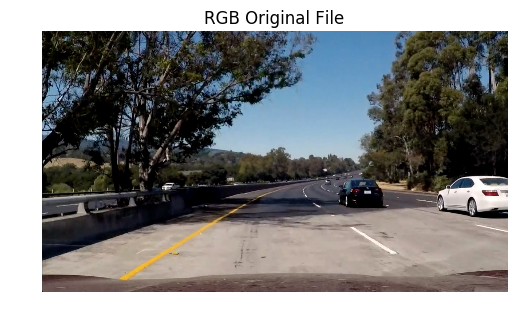

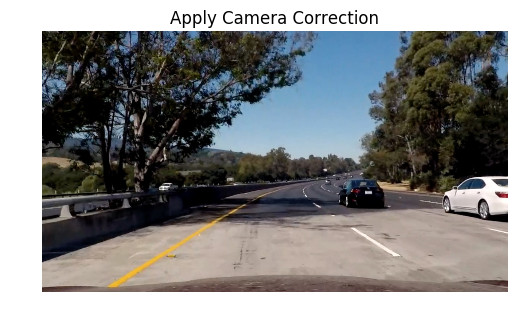

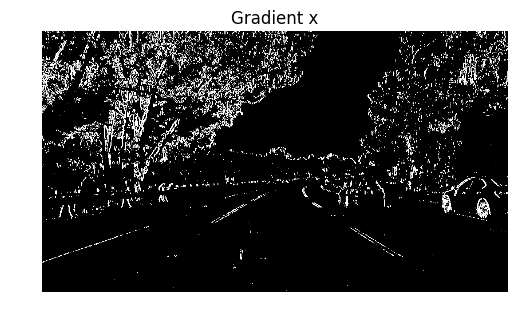

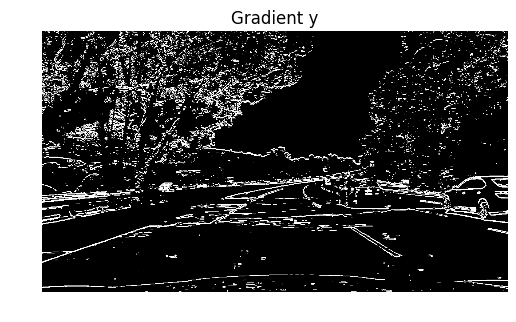

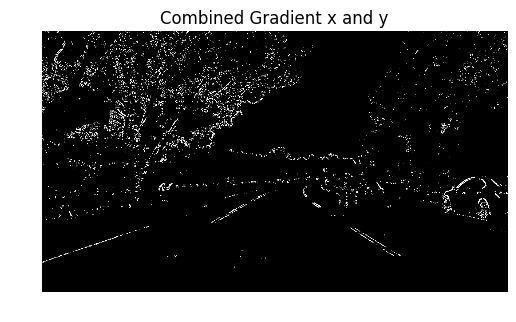

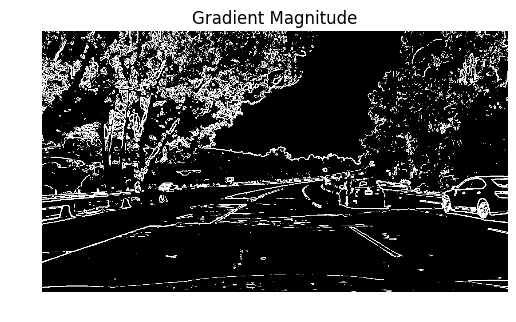

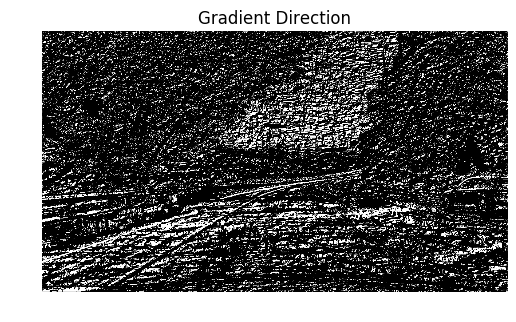

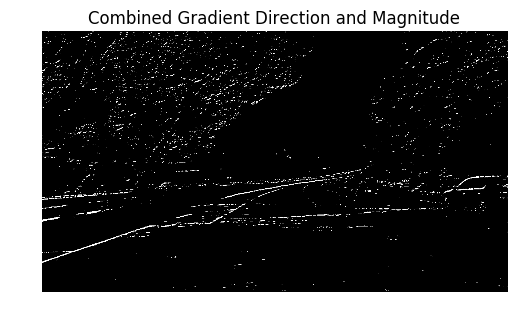

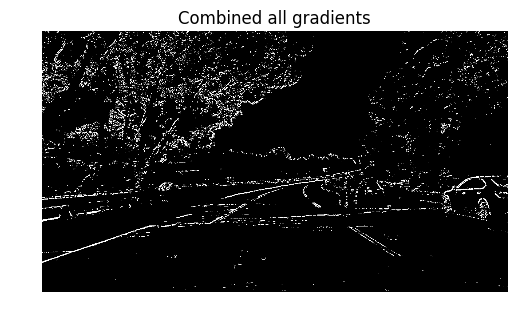

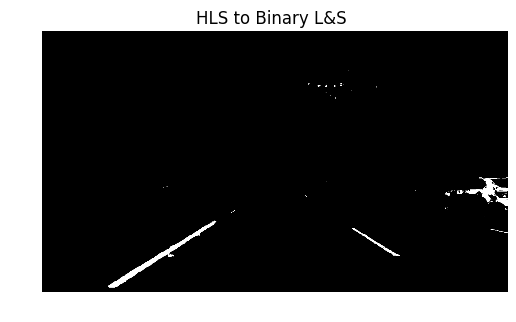

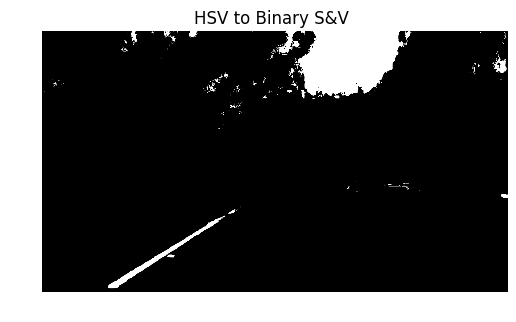

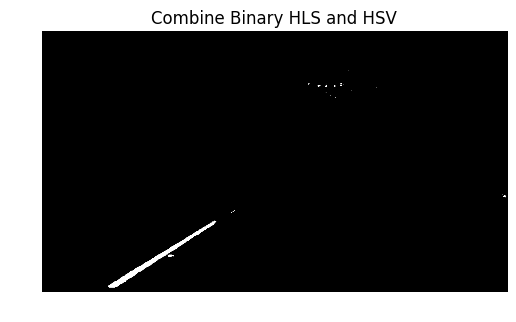

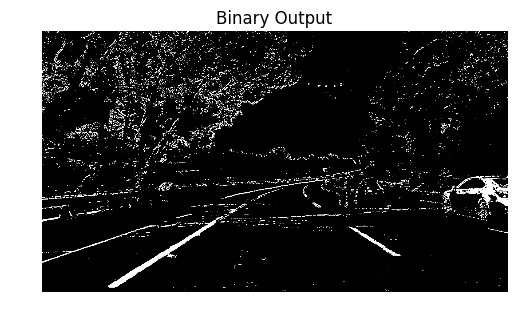

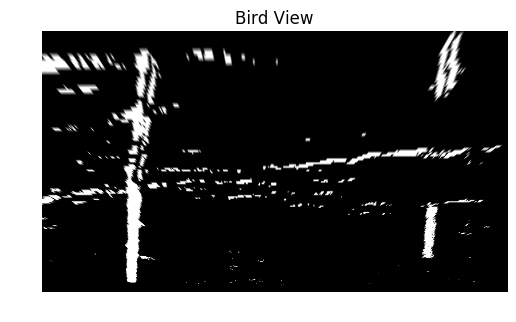

In [24]:
def display(img, title, color=1):
    if color:
        plt.imshow(img)
    else:
        plt.imshow(img, cmap='gray')
    plt.title(title)
    plt.axis('off')
    plt.show()


def process_pipeline(img, camera_calib_params, birdview_pts, showMe=0):
    process = Image_process()
    img = process.convert2_rgb(img)
    if showMe: display(img, 'RGB Original File')
    
    img = process.image_correction(img, camera_calib_params)
    if showMe: display(img, 'Apply Camera Correction')
    
    gradx = process.directional_gradient(img, direction='x', ksize=3, thresh=[25, 255] )
    if showMe: display(gradx, 'Gradient x', color=0)

    grady = process.directional_gradient(img, direction='y', ksize=3, thresh=[25, 255] ) #10, 100
    if showMe: display(grady, 'Gradient y', color=0)

    combined_xy = np.zeros_like(gradx)
    combined_xy[((gradx == 1) & (grady == 1))] = 1
    if showMe: display(combined_xy, 'Combined Gradient x and y', color=0)


    mag_binary = process.mag_gradient(img, ksize=3, thresh=(30, 255))
    if showMe: display(mag_binary, 'Gradient Magnitude', color=0)

    dir_binary = process.gradient_direction(img, ksize=3, thresh=[45, 90])
    if showMe: display(dir_binary, 'Gradient Direction', color=0)

    combined_magdir = np.zeros_like(dir_binary)
    combined_magdir[((mag_binary == 1) & (dir_binary == 1))] = 1
    if showMe: display(combined_magdir, 'Combined Gradient Direction and Magnitude', color=0)

    combined_gradients = np.zeros_like(dir_binary)
    combined_gradients[((gradx == 1) & (grady == 1)) | ((mag_binary == 1) & (dir_binary == 1))] = 1
    if showMe: display(combined_gradients, 'Combined all gradients', color=0)

    hls_binary = process.color_binary(img, 'HLS', ch2_thresh=[100,255], ch3_thresh=[120,255])
    if showMe: display(hls_binary, 'HLS to Binary L&S ', color=0)

    hsv_binary = process.color_binary(img, 'HSV', ch2_thresh=[110,255], ch3_thresh=[120,255])
    if showMe: display(hsv_binary, 'HSV to Binary S&V ', color=0)
    
    combined_color = np.zeros_like(hsv_binary)
    combined_color[(hls_binary==1) & (hsv_binary==1)] = 1
    if showMe: display(combined_color, 'Combine Binary HLS and HSV', color=0)
        
    output_binary = np.zeros_like(gradx)
    output_binary[(combined_gradients==1) | (hls_binary==1)] = 1
    if showMe: display(output_binary, 'Binary Output', color=0)
        
    img_warped = process.birdView(output_binary, birdview_pts)
    if showMe: display(img_warped, 'Bird View', color=0)
        
    return img_warped   
        

src_pts = np.float32([[275, 670], [545, 480], [740, 480], [1040, 670]])
dst_pts = np.float32([[275, 670], [250, 100], [1060, 100], [1040, 670]])
birdview_pts = {'src_pts': src_pts, 'dst_pts': dst_pts}
test_imgs = glob.glob('test_images/*.jpg')
img_pick = np.random.choice(test_imgs)
img = cv2.imread(img_pick)       
        
warped_img = process_pipeline(img, cal_params, birdview_pts, showMe=1)

# Finding Lanes

In [25]:
import matplotlib.patches as patches
from scipy.optimize import curve_fit


class FindingLanes():
    
    
    def __init__(self, image, bottom_crop, sliding_window, hot_pixel_thresh):
        self.image = image
        self.bottom_crop = bottom_crop
        self.hot_pixel_thresh = hot_pixel_thresh
        self.sliding_window = sliding_window
        #adjust image height (remove front-end of car)
        self.image = self.image[0:self.bottom_crop, :]
        
        
        
    def find_starter_centroids(self, hot_pixel_thresh):
        '''
        find starter centroid using bottom half of the image if in the histogram number of pixels in window is larger 
        than a threshold set by user (hot_pixel_thresh)
        If not use the full height of the image
        a window is defined by (x0, y0, width and height)
        '''
        window_l = {'x0': 0, 'y0': self.image.shape[0], 
                    'width':self.image.shape[1]/2, 'height':self.image.shape[0]/2}
        centroid_l, hot_pixel_cnt_l = self.find_centroid(self.image, window_l, display=0)
        if (hot_pixel_cnt_l < hot_pixel_thresh):
            window_l['height']=self.image.shape[0]
            centroid_l, hot_pixel_cnt_l = self.find_centroid(self.image, window_l, display=0)
            
        window_r = {'x0': self.image.shape[1]/2, 'y0': self.image.shape[0], 'width':self.image.shape[1]/2, 
                    'height':self.image.shape[0]/2}
        centroid_r, hot_pixel_cnt_r = self.find_centroid(self.image, window_r, display=0)
        
        if (hot_pixel_cnt_r < hot_pixel_thresh):
            window_r['height']=self.image.shape[0]
            centroid_r, hot_pixel_cnt_r = self.find_centroid(self.image, window_r, display=0)
        #only interested in rough estimate of the line
        return {'left': [centroid_l, hot_pixel_cnt_l], 'right':[centroid_r, hot_pixel_cnt_r]}

    
    
    def find_centroid(self, img, window, display=0):
        '''
        find centroid or mass center in window
        a window is defined by (x0, y0, width and height)
        if hotpixel_cnt (number of pixel in window is smaller than a threshold, 
        take centroid as center of window)
        '''
        #crop image to window dimension
        crop_image = img[ round( window['y0'] - window['height']):round(window['y0']), 
                              round(window['x0']):round(window['x0']+ window['width'])]
        
        histogram = np.sum(crop_image, axis=0)
        plt.imshow(crop_image)
        plt.show()
        hot_pixel_cnt = np.sum(histogram)
        plt.plot(histogram)
        plt.show()
        if hot_pixel_cnt > self.hot_pixel_thresh:
            #fit histogram to gaussian curve
            centroid = np.argmax(histogram)
            centroid = int( round(centroid + window['x0']) )
        else:
            centroid = int( round(window['x0'] + window['width']/2) )  
        
        return (centroid, hot_pixel_cnt)   
    
   
    def find_hotpixels(self, window):
        #window(x0, y0, width, height)
        
        crop_image = self.image[ (window['y0']-window['height']):window['y0'], 
                              window['x0']:window['x0']+window['width']]
        # find hotpixels coordinates in crop_image
        hotpixels_y, hotpixels_x = np.nonzero(crop_image)
        # hotpixels coordinate in full image axis
        hotpixels_x, hotpixels_y = hotpixels_x + window['x0'], window['y0']-hotpixels_y
        return (hotpixels_y, hotpixels_x)
    

    
    def run_sliding_window(self, centroid_starter):
        #define window(x0, y0, width, height)
        #initialize starting window
        window = {'x0': centroid_starter - int(self.sliding_window['width']/2), 'y0': self.image.shape[0],
                 'width': self.sliding_window['width'], 
                  'height': round(self.image.shape[0]/self.sliding_window['n_steps'])}
        #record hotpixels x/y coordinates
        hotpixels_x_log = []
        hotpixels_y_log = []
        #record centroid xy position and number of hotpixels
        centroids_log = []
        
        for step in range(self.sliding_window['n_steps']):
            hotpixels_x, hotpixels_y = self.find_hotpixels(window)
            #Get x coordinate centroid to move window
            centroid, hotpixel_cnt = self.find_centroid(self.image, window, display=1)
            #update logs - turn array into list
            if len(hotpixels_x) != 0:
                hotpixels_x_log.append(hotpixels_x.tolist())
                hotpixels_y_log.append(hotpixels_y.tolist())
            centroids_log.append([[centroid, window['y0']], hotpixel_cnt])
            #update window new position
            window['x0'] = round(centroid - window['width']/2)
            window['y0'] = window['y0'] - window['height']
            fig,ax = plt.subplots(1)
            ax.imshow(self.image, cmap='gray')
            ax.plot(centroid,int(window['y0'] + window['height']/2), 'r.')
            rect = patches.Rectangle((round(centroid- window['width']/2),window['y0']),window['width'],window['height'],
                                     linewidth=1,edgecolor='r',facecolor='none')
            #Add the patch to the Axes
            ax.add_patch(rect)
            ax.axis('off')
            plt.title('Sliding windows')
            plt.show()
        #store the hotpixels log data as flatten lists only if hot_pixels_x not empty
        if len(hotpixels_x_log) != 0 and len(hotpixels_x_log) != 0:
            x_log = [item for sublist in hotpixels_x_log for item in sublist]
            y_log = [item for sublist in hotpixels_y_log for item in sublist]
            return {'hotpixels_log': [x_log, y_log], 'centroids_log': centroids_log}
        else:
            return {'hotpixels_log': [hotpixels_x_log, hotpixels_y_log], 'centroids_log': centroids_log}

Size of Binary image (before crop):(720, 1280)
56156.0


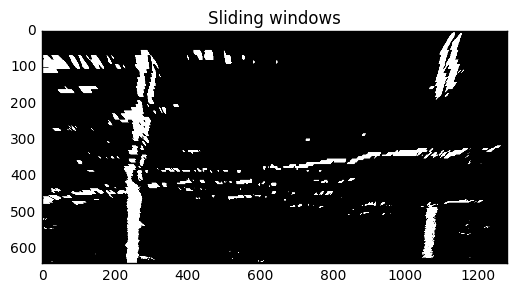

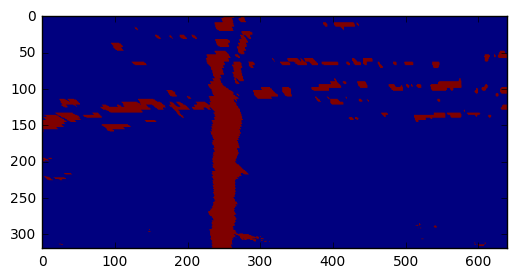

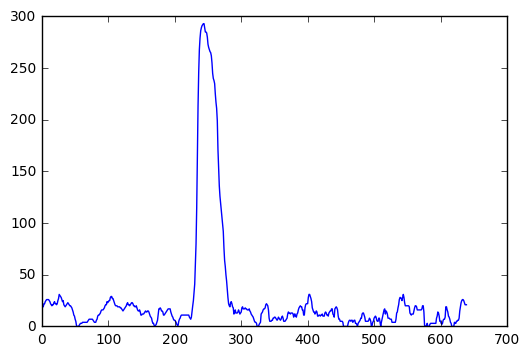

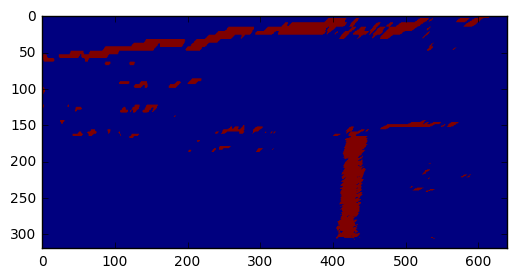

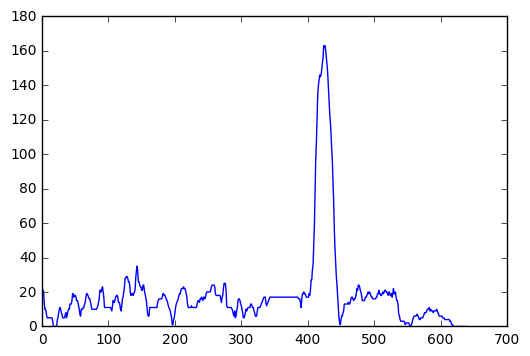

Hot pixel count centroid left 17218.0 | right 12020.0
Centroid starting position:  left 243 | right 1064


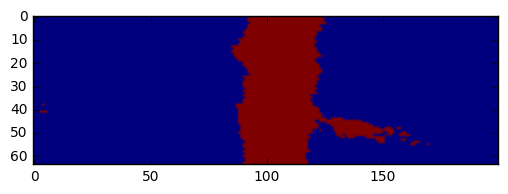

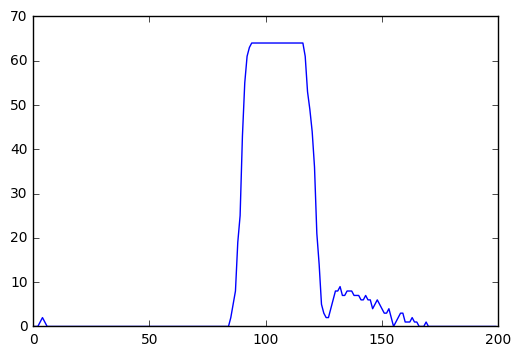

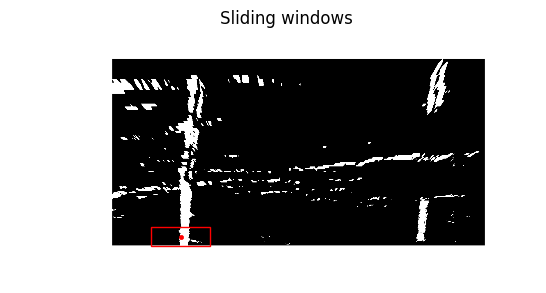

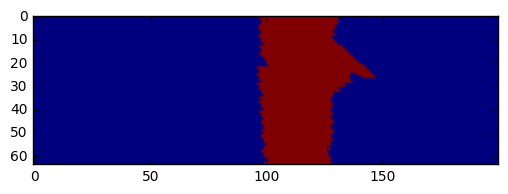

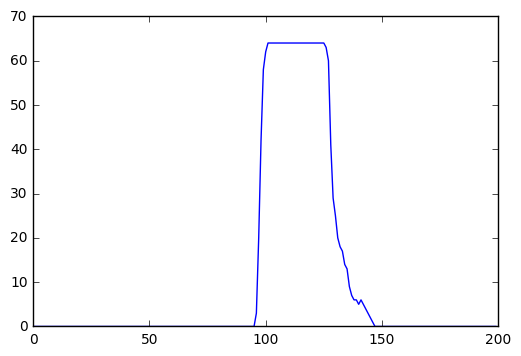

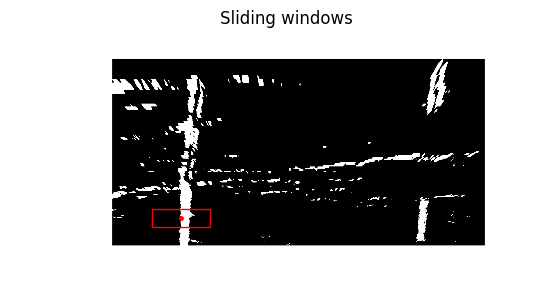

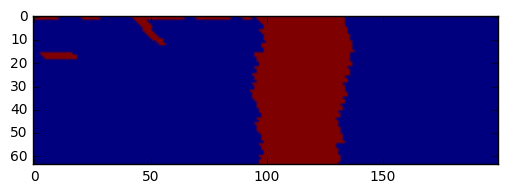

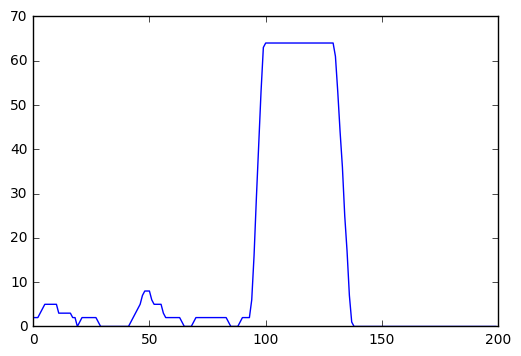

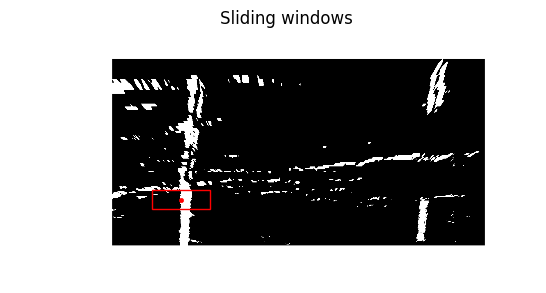

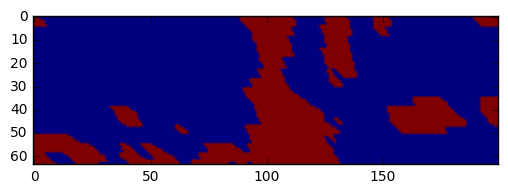

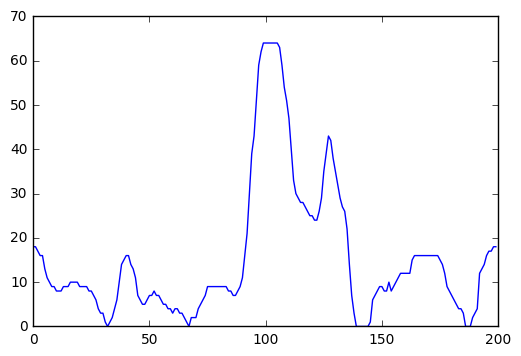

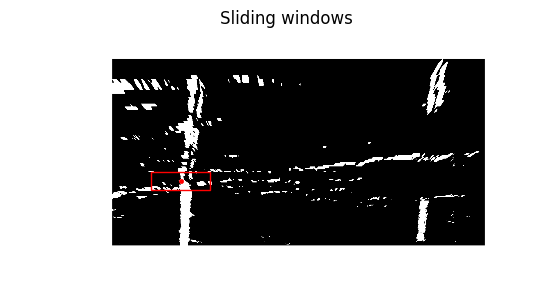

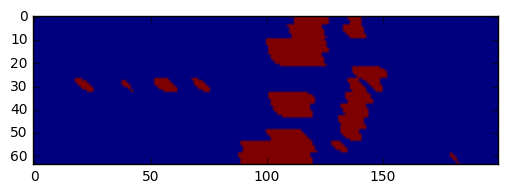

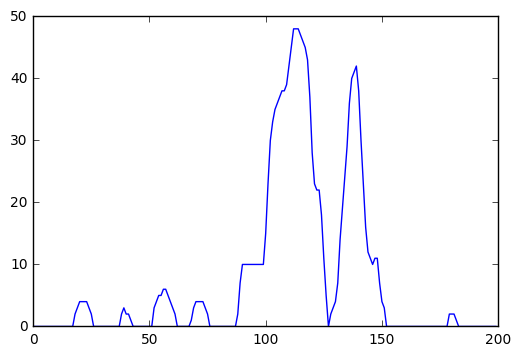

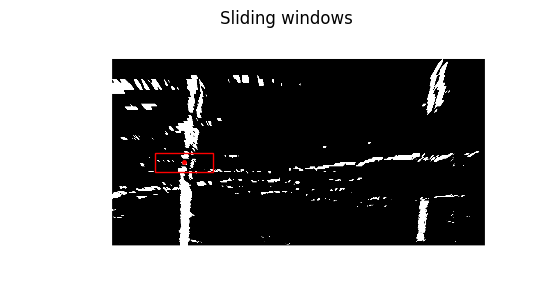

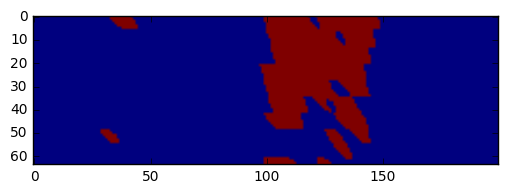

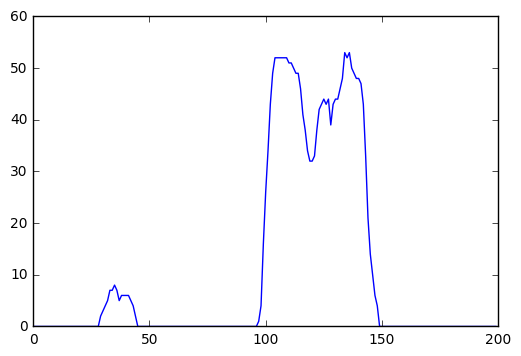

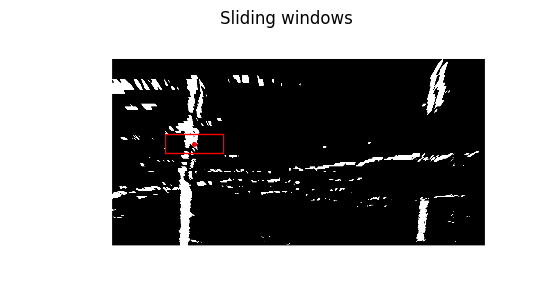

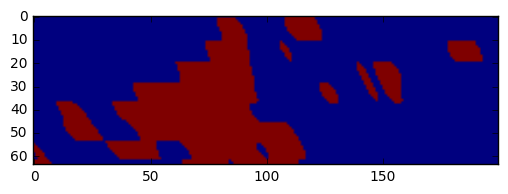

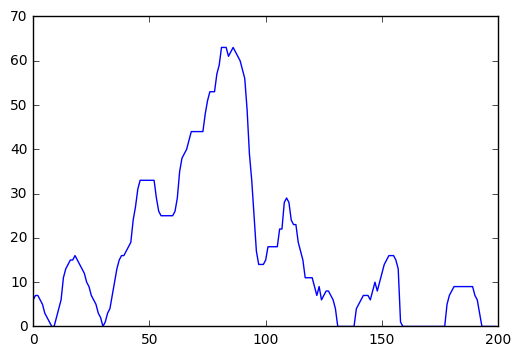

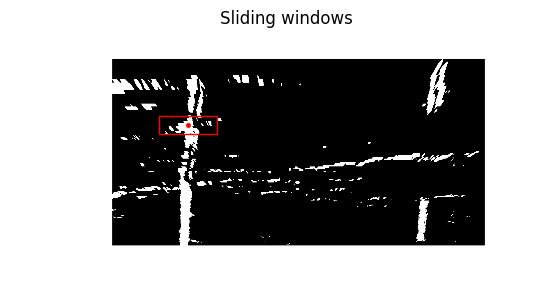

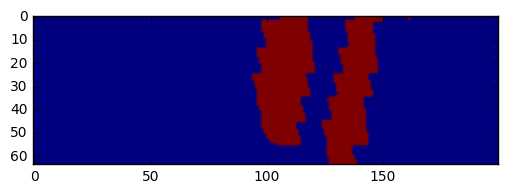

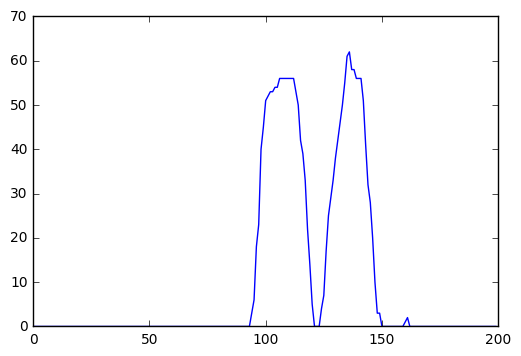

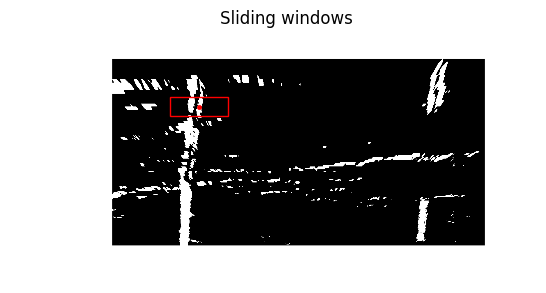

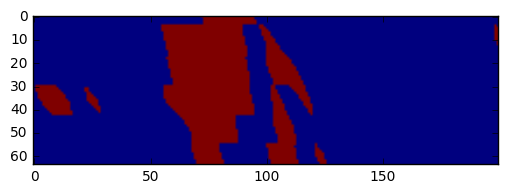

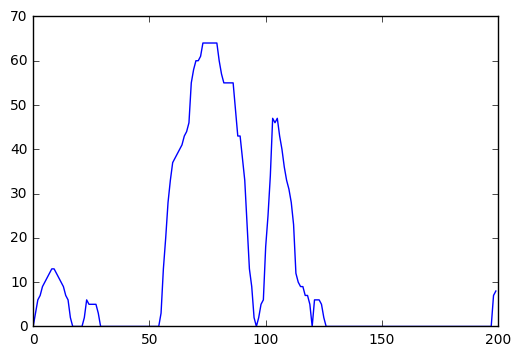

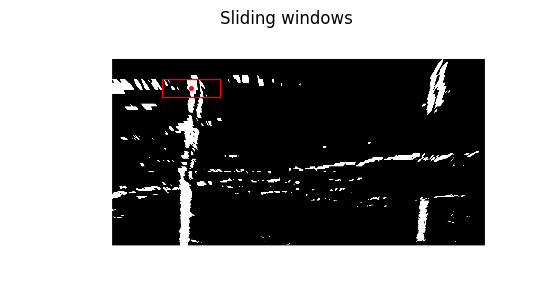

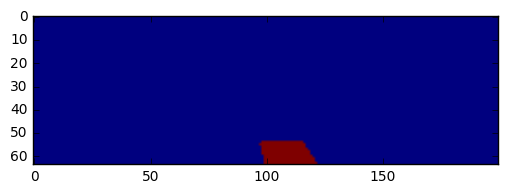

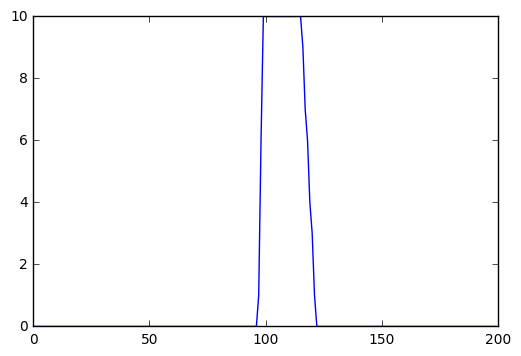

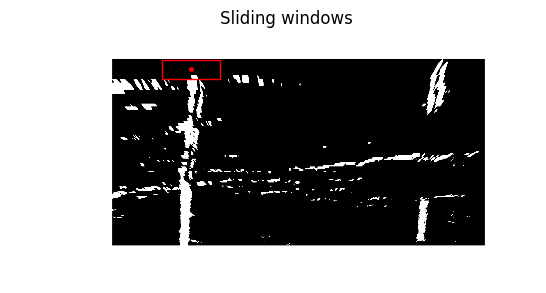

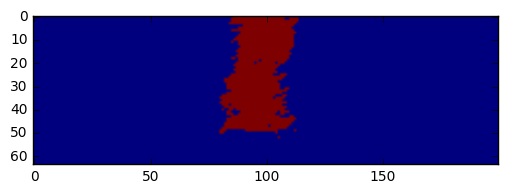

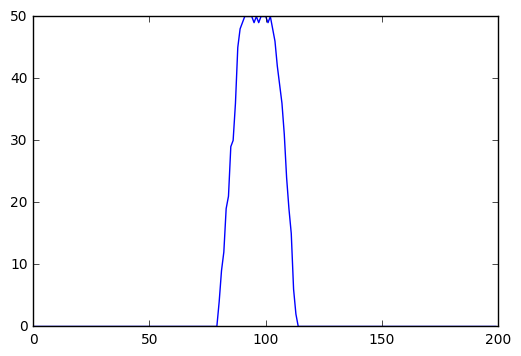

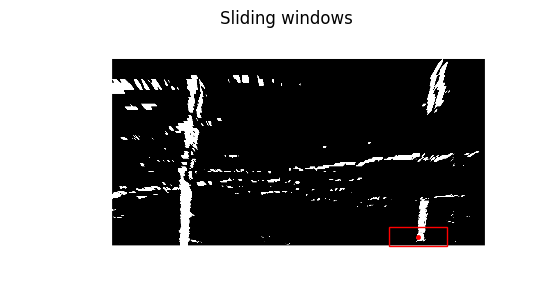

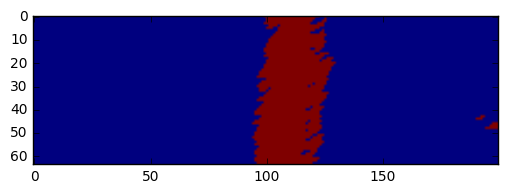

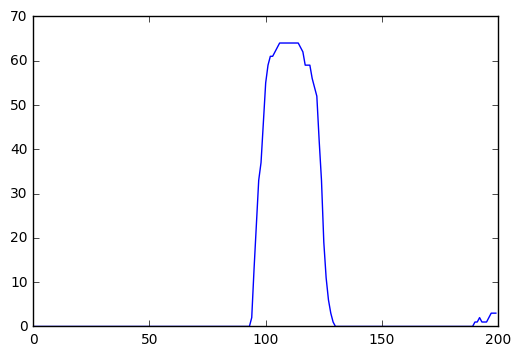

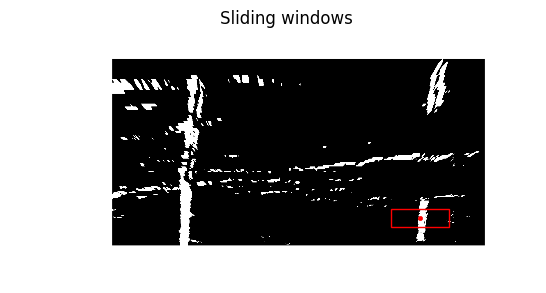

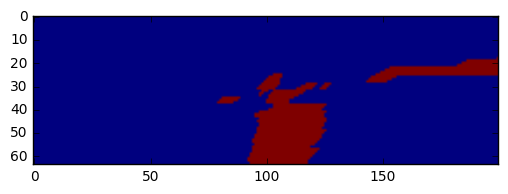

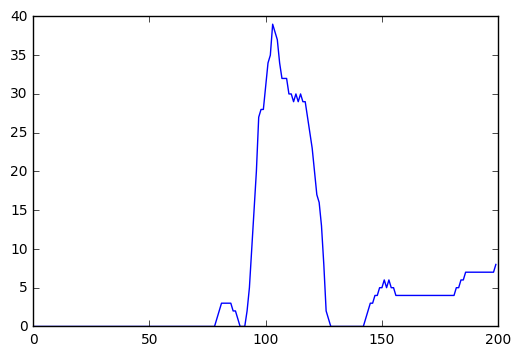

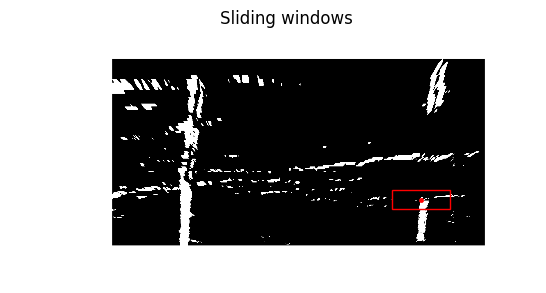

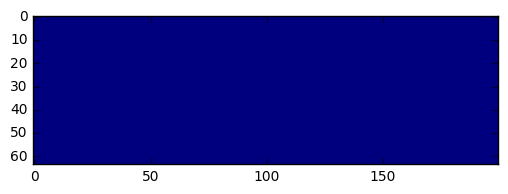

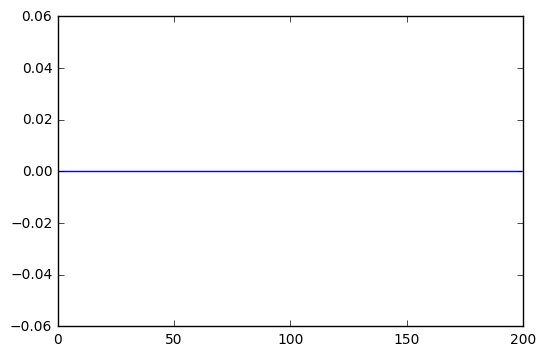

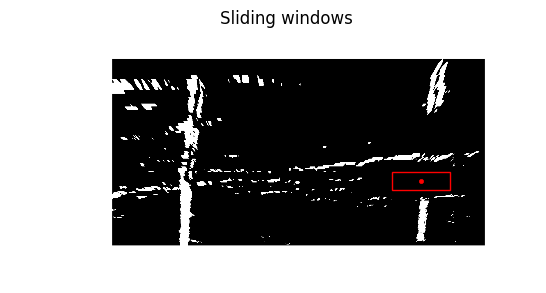

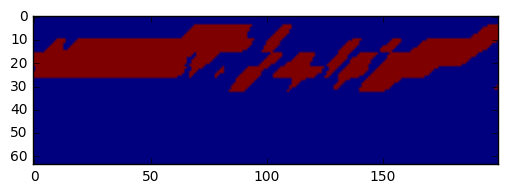

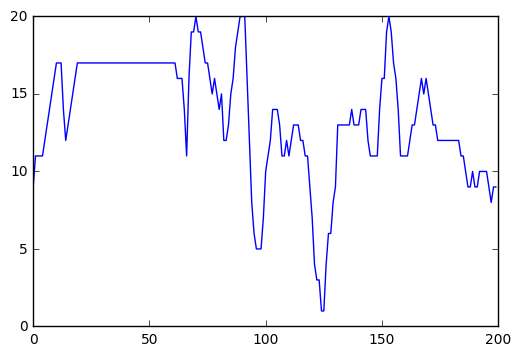

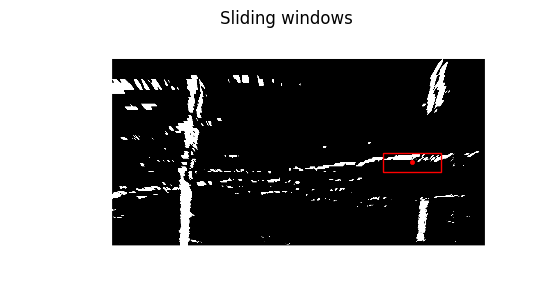

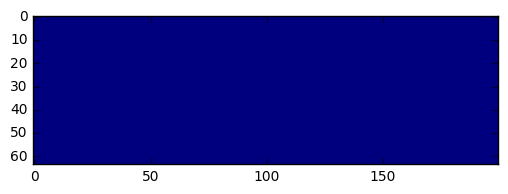

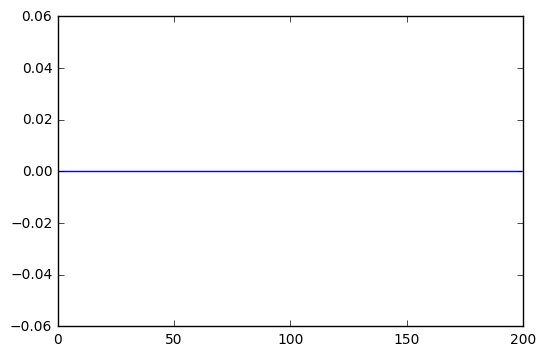

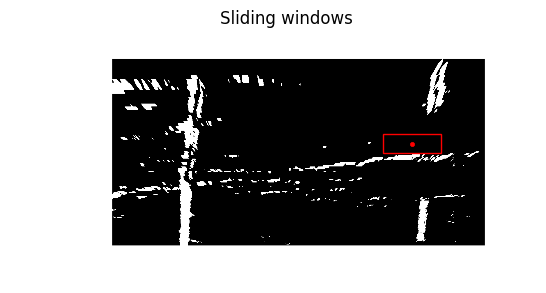

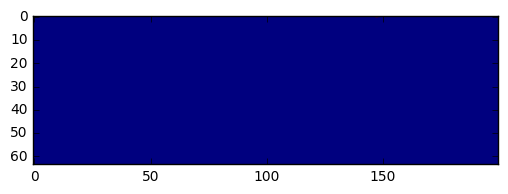

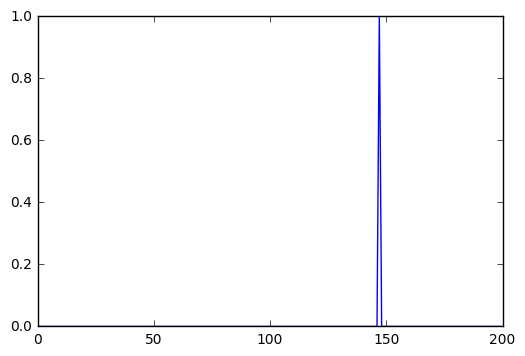

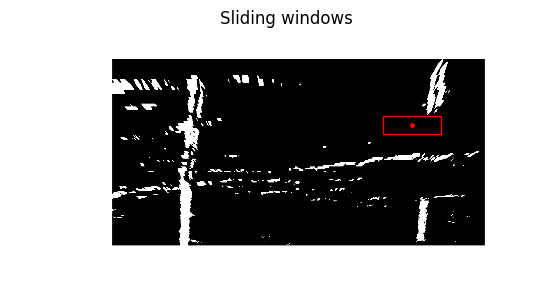

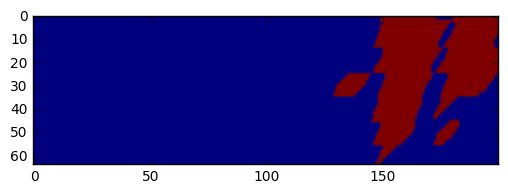

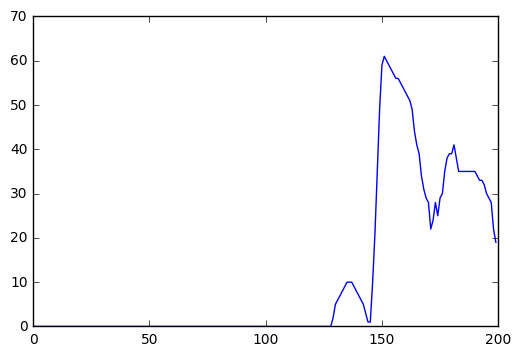

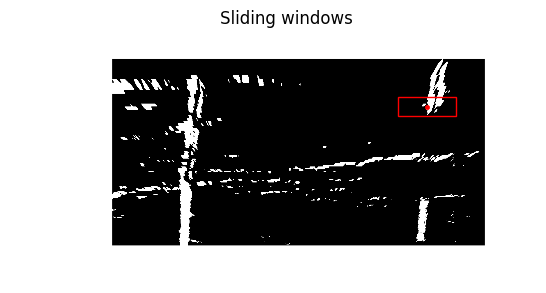

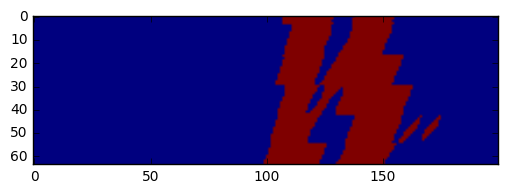

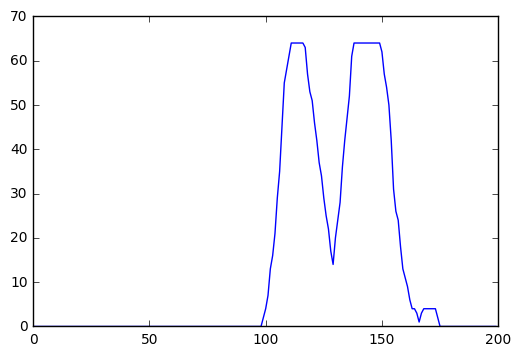

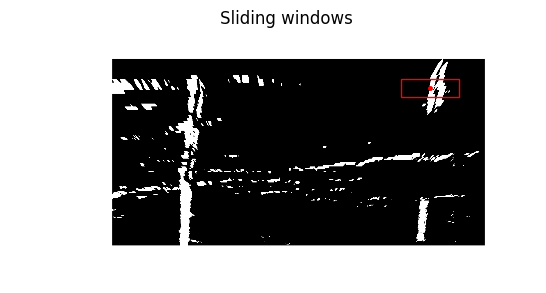

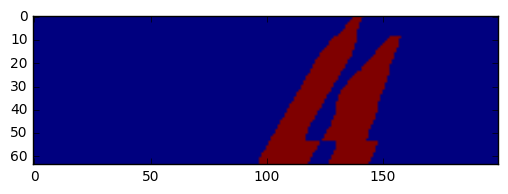

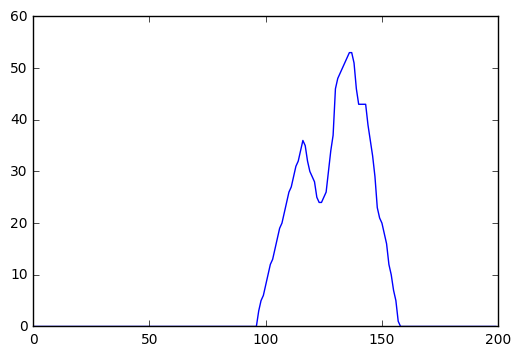

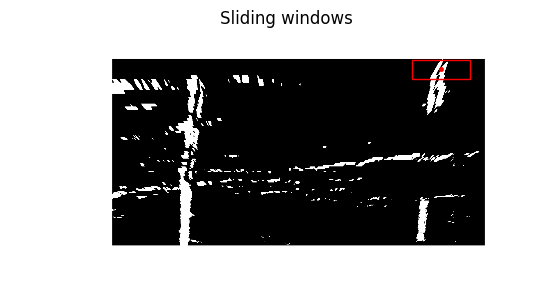

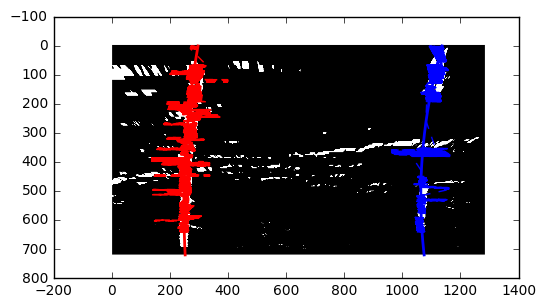

In [26]:



def polynomial_fit(x , y):
    # a0 + a1 x + a2 x**2
    a2, a1, a0 = np.polyfit(x, y, 2)
    return {'a0': a0, 'a1': a1, 'a2': a2}


def reject_outliers(data, m = 2.):
    d = np.abs(data - np.median(data))
    mdev = np.median(d)
    s = d/mdev if mdev else 0.
    return data[s<m]


binary_img = np.zeros_like(warped_img)
binary_img[warped_img >= 0.5] = 1

print('Size of Binary image (before crop):{}'.format(binary_img.shape))
print(np.sum(binary_img))

fig,ax = plt.subplots(1)
ax.imshow(binary_img[0:640, :], cmap='gray')
#rect = patches.Rectangle((175,576),200,64, linewidth=1,edgecolor='r',facecolor='none')
            #Add the patch to the Axes
#ax.add_patch(rect)
#ax.axis('off')
plt.title('Sliding windows')
plt.show()

#plt.axis('off')
plt.show()
bottom_crop = -80 #front-end car
#sliding_window = {'width': 200, 'height': int(img_height/n_steps), 'n_steps': n_steps}
n_steps = 10 #number of steps vertical steps of sliding window
sliding_window_specs = {'width': 200, 'n_steps': n_steps}

n_histogram_peaks = 3
centroid_type = 'all_hot_pixel'  #single_point
hot_pixel_thresh = 50 # if number of hot pixel in window below 50, 
#consider them as noise and do not attempt to get centroid
lanes = FindingLanes(binary_img, bottom_crop, sliding_window_specs, hot_pixel_thresh)

#hot_pixel_thresh : if the half window contain hot pixel below the threshold, take histogram on full height
centroid_starters = lanes.find_starter_centroids(hot_pixel_thresh=1400)
centroid_starter_right = centroid_starters['right']
centroid_starter_left = centroid_starters['left']
print('Hot pixel count centroid left {} | right {}'.format(centroid_starter_left[1], centroid_starter_right[1]))
print('Centroid starting position:  left {} | right {}'.format(centroid_starter_left[0], centroid_starter_right[0]))

# record left/right lane hotpixels coordinates x and y
left_lane = lanes.run_sliding_window(centroid_starter_left[0])
hotpixels_log_left, centroids_log_left = left_lane['hotpixels_log'], left_lane['centroids_log']
right_lane = lanes.run_sliding_window(centroid_starter_right[0])
hotpixels_log_right, centroids_log_right = right_lane['hotpixels_log'], right_lane['centroids_log']

#Get polynomial fit left:
height_pts = np.linspace(0, binary_img.shape[0]-1, num=binary_img.shape[0])

if len(hotpixels_log_left[0]) != 0 and len(hotpixels_log_left[1]) != 0:
    fit_left = polynomial_fit(hotpixels_log_left[0] , hotpixels_log_left[1])
    #predicted left lane
    pred_leftLane = fit_left['a2']*height_pts**2 + fit_left['a1']*height_pts + fit_left['a0'] 
else:
    print('use previous frame data')

if len(hotpixels_log_right[0]) != 0 and len(hotpixels_log_right[1]) != 0:
    fit_right = polynomial_fit(hotpixels_log_right[0] , hotpixels_log_right[1])
    pred_rightLane = fit_right['a2']*height_pts**2 + fit_right['a1']*height_pts + fit_right['a0'] 
else:
    print('use previous frame data')

#Display fit
plt.imshow(binary_img, cmap='gray')
plt.plot(hotpixels_log_left[1], hotpixels_log_left[0], 'r--')
plt.plot(pred_leftLane, height_pts, 'r-', linewidth=2)
plt.plot(hotpixels_log_right[1], hotpixels_log_right[0], 'b--')
plt.plot(pred_rightLane, height_pts, 'b-', linewidth=2)
plt.show()

#

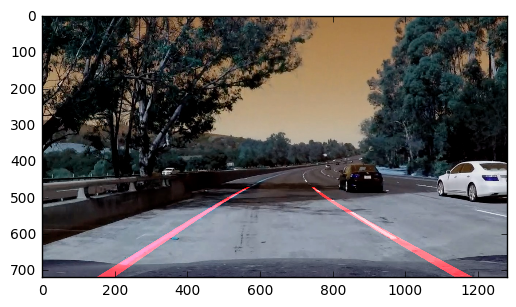

In [27]:
# Draw prediction/fir as thick lines

left_lane = np.concatenate((pred_leftLane - 20, pred_leftLane[::-1]+20), axis=0)
h_pts = np.concatenate((height_pts, height_pts[::-1]), axis=0)
l = np.array(list(zip(left_lane, h_pts)), np.int32)

right_lane = np.concatenate((pred_rightLane - 20, pred_rightLane[::-1]+20), axis=0)
r = np.array(list(zip(right_lane, h_pts)), np.int32)

road = np.zeros_like(img)
cv2.fillPoly(road, [l], color=[255, 0, 0])
cv2.fillPoly(road, [r], color=[255, 0, 0])

img_size = binary_img.shape[::-1]

road_warped = cv2.warpPerspective(road, Minv, img_size, flags=cv2.INTER_LINEAR)
result = cv2.addWeighted(img, 0.9, road_warped, 1.0, 0.0)
plt.imshow(result)

In [28]:
round(0.902)

1

In [29]:
xm_per_px = 120/10
ym_per_px = 510/4

# calculate car offset versus middle_road
center_car = img.shape[1]/2
car_offset = (img.shape[1]/2 - (pred_leftLane[-1] + pred_rightLane[-1]))
#scaling
car_offset = car_offset * xm_per_pix
if car_offset < 0:
    car_pos = 'left'
    
radiusCurvature_text = str(round(curved, 3))+'(m)', (50, 50)
car_offset_text = str(abs(round(car_offset, 3)))+'m'+car_pos+'of center', (50, 100),
cv2.putText(result, 'Radius of Curvature= '+radiusCurvature_text, cv2.FONT_HERSHEY_SIMPLEX, 1, (255, 255, 255), 2)
cv2.putText(result, 'Vehicle offset from center: '+car_offset_text, cv2.FONT_HERSHEY_SIMPLEX, 1, (255, 255, 255), 2)
plt.imshow(result)

NameError: name 'xm_per_pix' is not defined

In [ ]:
import matplotlib.patches as patches
from scipy.optimize import curve_fit


class FindingLanes():
    
    
    def __init__(self, image, bottom_crop, sliding_window, hot_pixel_thresh):
        self.image = image
        self.bottom_crop = bottom_crop
        self.hot_pixel_thresh = hot_pixel_thresh
        self.sliding_window = sliding_window
        #adjust image height (remove front-end of car)
        self.image = self.image[0:self.bottom_crop, :]
    
    
    def gaussian(self, x, amplitude, mean, sigma):
        return amplitude * np.exp(-(x-mean)**2 /sigma)
 

    def gaussian_fit(self, x, y, init_values):
        #init values [amplitude, mean, sigma]
        best_values, covar = curve_fit(self.gaussian, x, y, p0=init_values)
        return best_values
        
        
    def find_starter_centroids(self, hot_pixel_thresh):
        '''
        find starter centroid using bottom half of the image if in the histogram number of pixels in window is larger 
        than a threshold set by user (hot_pixel_thresh)
        If not use the full height of the image
        a window is defined by (x0, y0, width and height)
        '''
        window_l = {'x0': 0, 'y0': self.image.shape[0], 
                    'width':self.image.shape[1]/2, 'height':self.image.shape[0]/2}
        centroid_l, hot_pixel_cnt_l = self.find_centroid(self.image, window_l, display=0)
        if (hot_pixel_cnt_l < hot_pixel_thresh):
            window_l['height']=self.image.shape[0]
            centroid_l, hot_pixel_cnt_l = self.find_centroid(self.image, window_l, display=0)
            
        window_r = {'x0': self.image.shape[1]/2, 'y0': self.image.shape[0], 'width':self.image.shape[1]/2, 
                    'height':self.image.shape[0]/2}
        centroid_r, hot_pixel_cnt_r = self.find_centroid(self.image, window_r, display=0)
        
        if (hot_pixel_cnt_r < hot_pixel_thresh):
            window_r['height']=self.image.shape[0]
            centroid_r, hot_pixel_cnt_r = self.find_centroid(self.image, window_r, display=0)
        #only interested in rough estimate of the line
        return {'left': [centroid_l, hot_pixel_cnt_l], 'right':[centroid_r, hot_pixel_cnt_r]}

    
    
    def find_centroid(self, img, window, display=0):
        '''
        find centroid or mass center in window
        a window is defined by (x0, y0, width and height)
        if hotpixel_cnt (number of pixel in window is smaller than a threshold, 
        take centroid as center of window)
        '''
        #crop image to window dimension
        crop_image = img[ round( window['y0'] - window['height']):round(window['y0']), 
                              round(window['x0']):round(window['x0']+ window['width'])]
        histogram = np.sum(crop_image, axis=0)
        plt.plot(histogram)
        plt.show()
        hot_pixel_cnt = np.sum(histogram)
        if hot_pixel_cnt > self.hot_pixel_thresh:
            #fit histogram to gaussian curve
            position_peak = np.argmax(histogram)
            init_vals = [self.hot_pixel_thresh, position_peak, position_peak/4]     #init values [amplitude, mean, sigma]
            
            try:
                x = np.array(range(len(histogram)))
                _, centroid_fit, sigma = self.gaussian_fit(x, histogram, init_vals)
                centroid = round(centroid_fit)
            except:
                centroid = position_peak
            centroid = int( round(centroid + window['x0']) )
        else:
            centroid = int( round(window['x0'] + window['width']/2) )  
        
        return (centroid, hot_pixel_cnt)   
    
   
    def find_hotpixels(self, window):
        #window(x0, y0, width, height)
        
        crop_image = self.image[ (window['y0']-window['height']):window['y0'], 
                              window['x0']:window['x0']+window['width']]
        # find hotpixels coordinates in crop_image
        hotpixels_y, hotpixels_x = np.nonzero(crop_image)
        # hotpixels coordinate in full image axis
        hotpixels_x, hotpixels_y = hotpixels_x + window['x0'], window['y0']-hotpixels_y
        return (hotpixels_y, hotpixels_x)
    

    
    def run_sliding_window(self, centroid_starter):
        #define window(x0, y0, width, height)
        #initialize starting window
        window = {'x0': centroid_starter - int(self.sliding_window['width']/2), 'y0': self.image.shape[0],
                 'width': self.sliding_window['width'], 
                  'height': round(self.image.shape[0]/self.sliding_window['n_steps'])}
        #record hotpixels x/y coordinates
        hotpixels_x_log = []
        hotpixels_y_log = []
        #record centroid xy position and number of hotpixels
        centroids_log = []
        
        for step in range(self.sliding_window['n_steps']):
            #Disable box outside the image
            if (window['x0'] < 0): window['x0'] = 0
            if (window['x0'] + window['width']) > self.image.shape[1]: window['x0']=self.image.shape[1]-window['width']
            hotpixels_x, hotpixels_y = self.find_hotpixels(window)
            #Get x coordinate centroid to move window
            centroid, hotpixel_cnt = self.find_centroid(self.image, window, display=1)
            #update logs - turn array into list
            if len(hotpixels_x) != 0:
                hotpixels_x_log.append(hotpixels_x.tolist())
                hotpixels_y_log.append(hotpixels_y.tolist())
            centroids_log.append([[centroid, window['y0']], hotpixel_cnt])
            #update window new position
            window['x0'] = round(centroid - window['width']/2)
            window['y0'] = window['y0'] - window['height']
            fig,ax = plt.subplots(1)
            ax.imshow(self.image, cmap='gray')
            ax.plot(centroid,int(window['y0'] + window['height']/2), 'r.')
            rect = patches.Rectangle((round(centroid- window['width']/2),window['y0']),window['width'],window['height'],
                                     linewidth=1,edgecolor='r',facecolor='none')
            #Add the patch to the Axes
            ax.add_patch(rect)
            ax.axis('off')
            plt.title('Sliding windows')
            plt.show()
        #store the hotpixels log data as flatten lists only if hot_pixels_x not empty
        if len(hotpixels_x_log) != 0 and len(hotpixels_x_log) != 0:
            x_log = [item for sublist in hotpixels_x_log for item in sublist]
            y_log = [item for sublist in hotpixels_y_log for item in sublist]
            return {'hotpixels_log': [x_log, y_log], 'centroids_log': centroids_log}
        else:
            return {'hotpixels_log': [hotpixels_x_log, hotpixels_y_log], 'centroids_log': centroids_log}

# Harder challenge image

In [ ]:
image = cv2.imread('harder-test/004.jpg')


src_pts = np.float32([[275, 670], [545, 480], [740, 480], [1040, 670]])
dst_pts = np.float32([[275, 670], [250, 100], [1060, 100], [1040, 670]])
birdview_pts = {'src_pts': src_pts, 'dst_pts': dst_pts}
warped_img = process_pipeline(image, cal_params, birdview_pts, showMe=0)
plt.imshow(warped_img)
plt.show()
binary_img = np.zeros_like(warped_img)
binary_img[warped_img >= 0.5] = 1
bottom_crop = -80 #front-end car
#sliding_window = {'width': 200, 'height': int(img_height/n_steps), 'n_steps': n_steps}
n_steps = 10 #number of steps vertical steps of sliding window
sliding_window_specs = {'width': 200, 'n_steps': n_steps}

hot_pixel_thresh = 50 # if number of hot pixel in window below 50, 
#consider them as noise and do not attempt to get centroid
lanes = FindingLanes(binary_img, bottom_crop, sliding_window_specs, hot_pixel_thresh)

#hot_pixel_thresh : if the half window contain hot pixel below the threshold, take histogram on full height
centroid_starters = lanes.find_starter_centroids(hot_pixel_thresh=1400)
centroid_starter_right = centroid_starters['right']
print(centroid_starter_right)
centroid_starter_left = centroid_starters['left']
# record left/right lane hotpixels coordinates x and y
left_lane = lanes.run_sliding_window(centroid_starter_left[0])
hotpixels_log_left, centroids_log_left = left_lane['hotpixels_log'], left_lane['centroids_log']
right_lane = lanes.run_sliding_window(centroid_starter_right[0])
hotpixels_log_right, centroids_log_right = right_lane['hotpixels_log'], right_lane['centroids_log']

#Get polynomial fit left:
height_pts = np.linspace(0, binary_img.shape[0]-1, num=binary_img.shape[0])

if len(hotpixels_log_left[0]) != 0 and len(hotpixels_log_left[1]) != 0:
    fit_left = polynomial_fit(hotpixels_log_left[0] , hotpixels_log_left[1])
    #predicted left lane
    pred_leftLane = fit_left['a2']*height_pts**2 + fit_left['a1']*height_pts + fit_left['a0'] 
else:
    print('use previous frame data')

if len(hotpixels_log_right[0]) != 0 and len(hotpixels_log_right[1]) != 0:
    fit_right = polynomial_fit(hotpixels_log_right[0] , hotpixels_log_right[1])
    pred_rightLane = fit_right['a2']*height_pts**2 + fit_right['a1']*height_pts + fit_right['a0'] 
else:
    print('use previous frame data')


    # Draw prediction/fit as thick lines
left_lane = np.concatenate((pred_leftLane - 20, pred_leftLane[::-1]+20), axis=0)
h_pts = np.concatenate((height_pts, height_pts[::-1]), axis=0)
l = np.array(list(zip(left_lane, h_pts)), np.int32)

right_lane = np.concatenate((pred_rightLane - 20, pred_rightLane[::-1]+20), axis=0)
r = np.array(list(zip(right_lane, h_pts)), np.int32)

road = np.zeros_like(image)
cv2.fillPoly(road, [l], color=[255, 0, 0])
cv2.fillPoly(road, [r], color=[255, 0, 0])

img_size = binary_img.shape[::-1]

road_warped = cv2.warpPerspective(road, Minv, img_size, flags=cv2.INTER_LINEAR)
result = cv2.addWeighted(image, 0.9, road_warped, 1.0, 0.0)
plt.imshow(result)
plt.show()

In [ ]:
# Import everything needed to edit/save/watch video clips
from moviepy.editor import VideoFileClip
from IPython.display import HTML


def process_image(image):
    # NOTE: The output you return should be a color image (3 channel) for processing video below
    # TODO: put your pipeline here,
    # you should return the final output (image with lines are drawn on lanes)
    # Turn off 'steps' to avoid high memory usage
    
    src_pts = np.float32([[275, 670], [545, 480], [740, 480], [1040, 670]])
    dst_pts = np.float32([[275, 670], [250, 100], [1060, 100], [1040, 670]])
    birdview_pts = {'src_pts': src_pts, 'dst_pts': dst_pts}
    warped_img = process_pipeline(image, cal_params, birdview_pts, showMe=0)
    #plt.imshow(warped_img)
    #plt.show()
    binary_img = np.zeros_like(warped_img)
    binary_img[warped_img >= 0.5] = 1
    bottom_crop = -80 #front-end car
    #sliding_window = {'width': 200, 'height': int(img_height/n_steps), 'n_steps': n_steps}
    n_steps = 10 #number of steps vertical steps of sliding window
    sliding_window_specs = {'width': 200, 'n_steps': n_steps}

    hot_pixel_thresh = 50 # if number of hot pixel in window below 50, 
    #consider them as noise and do not attempt to get centroid
    lanes = FindingLanes(binary_img, bottom_crop, sliding_window_specs, hot_pixel_thresh)

    #hot_pixel_thresh : if the half window contain hot pixel below the threshold, take histogram on full height
    centroid_starters = lanes.find_starter_centroids(hot_pixel_thresh=1400)
    centroid_starter_right = centroid_starters['right']
    centroid_starter_left = centroid_starters['left']
    # record left/right lane hotpixels coordinates x and y
    left_lane = lanes.run_sliding_window(centroid_starter_left[0])
    hotpixels_log_left, centroids_log_left = left_lane['hotpixels_log'], left_lane['centroids_log']
    right_lane = lanes.run_sliding_window(centroid_starter_right[0])
    hotpixels_log_right, centroids_log_right = right_lane['hotpixels_log'], right_lane['centroids_log']

    #Get polynomial fit left:
    height_pts = np.linspace(0, binary_img.shape[0]-1, num=binary_img.shape[0])

    if len(hotpixels_log_left[0]) != 0 and len(hotpixels_log_left[1]) != 0:
        fit_left = polynomial_fit(hotpixels_log_left[0] , hotpixels_log_left[1])
        #predicted left lane
        pred_leftLane = fit_left['a2']*height_pts**2 + fit_left['a1']*height_pts + fit_left['a0'] 
    else:
        print('use previous frame data')

    if len(hotpixels_log_right[0]) != 0 and len(hotpixels_log_right[1]) != 0:
        fit_right = polynomial_fit(hotpixels_log_right[0] , hotpixels_log_right[1])
        pred_rightLane = fit_right['a2']*height_pts**2 + fit_right['a1']*height_pts + fit_right['a0'] 
    else:
        print('use previous frame data')


    # Draw prediction/fit as thick lines
    left_lane = np.concatenate((pred_leftLane - 20, pred_leftLane[::-1]+20), axis=0)
    h_pts = np.concatenate((height_pts, height_pts[::-1]), axis=0)
    l = np.array(list(zip(left_lane, h_pts)), np.int32)

    right_lane = np.concatenate((pred_rightLane - 20, pred_rightLane[::-1]+20), axis=0)
    r = np.array(list(zip(right_lane, h_pts)), np.int32)

    road = np.zeros_like(image)
    cv2.fillPoly(road, [l], color=[255, 0, 0])
    cv2.fillPoly(road, [r], color=[255, 0, 0])

    img_size = binary_img.shape[::-1]

    road_warped = cv2.warpPerspective(road, Minv, img_size, flags=cv2.INTER_LINEAR)
    result = cv2.addWeighted(image, 0.9, road_warped, 1.0, 0.0)
    
    return result

white_output = 'harder.mp4'
clip1 = VideoFileClip("harder_challenge_video.mp4")
white_clip = clip1.fl_image(process_image) #NOTE: this function expects color images!!
%time white_clip.write_videofile(white_output, audio=False)

In [ ]:
# Important to not allow the x0 to get negative
#otherwise error and cannot extract crop image properly